In [ ]:
from __future__ import annotations

import itertools
from dataclasses import dataclass, field
from enum import Enum, auto
from typing import Any, Dict, Iterable, List, Optional, Set, Tuple, Callable

import networkx as nx
import sympy as sp
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

try:
    import pydot
    from networkx.drawing.nx_pydot import graphviz_layout
    HAS_PYDOT = True
except ImportError:
    HAS_PYDOT = False

import numpy as np
if not hasattr(np, 'alltrue'): # Shim for older numpy versions
    setattr(np, 'alltrue', np.all)


class NodeRole(Enum):
    COMPARTMENT = auto()
    EXTERIOR = auto()
    EXPR_OP = auto()
    EXPR_FUNCTION = auto()
    EXPR_SYMBOL = auto()
    EXPR_CONSTANT = auto()
    EDGE_PROXY = auto()

    def prefix(self) -> str:
        return {
            NodeRole.COMPARTMENT: "C",
            NodeRole.EXTERIOR: "X",
            NodeRole.EXPR_OP: "O",
            NodeRole.EXPR_FUNCTION: "F",
            # EXPR_SYMBOL prefix is handled by specific labels P:, U: in practice
            NodeRole.EXPR_SYMBOL: "S", # General symbol, though P: U: are used.
            NodeRole.EXPR_CONSTANT: "K",
            NodeRole.EDGE_PROXY: "EP",
        }[self]

class InteractionType(Enum):
    FLOW = "flow"

@dataclass
class NodeData:
    role: NodeRole
    label: str
    raw_label: str
    sympy_obj: Optional[sp.Basic] = None
    attrs: Dict[str, Any] = field(default_factory=dict)

    def as_dict(self) -> Dict[str, Any]:
        d = dict(role=self.role, label=self.label, raw_label=self.raw_label, **self.attrs)
        if self.sympy_obj is not None:
            # Store string representation for NetworkX, actual object remains in NodeData
            d["sympy_str"] = str(self.sympy_obj)
        return d

@dataclass
class Interaction:
    source: str
    target: str
    int_type: InteractionType
    expr_root: str # Node ID of the root of the expression subgraph

StateVarSet = Set[str]
ParamSet = Set[str]

# --- Expression Canonicalization Functions (largely unchanged) ---
def _depends_on(expr: sp.Basic, state_vars: StateVarSet) -> bool:
    if not isinstance(expr, sp.Basic):
        return False
    return any(str(s) in state_vars for s in expr.free_symbols)

def _expand_state_dependent_products(expr: sp.Basic, state_vars: StateVarSet) -> sp.Basic:
    if not isinstance(expr, sp.Basic): return expr
    processed_args = [_expand_state_dependent_products(a, state_vars) for a in expr.args]
    try: expr = expr.func(*processed_args)
    except Exception:
        try: expr = expr.func(*expr.args) # Fallback if processed_args causes issues
        except Exception: return expr # Ultimate fallback
    if not isinstance(expr, sp.Mul): return expr
    non_sums, sums_to_expand = [], []
    for arg in expr.args:
        if isinstance(arg, sp.Add) and _depends_on(arg, state_vars): sums_to_expand.append(arg)
        else: non_sums.append(arg)
    if not sums_to_expand: return expr
    prod_root = sp.Mul(*non_sums) if non_sums else sp.Integer(1)
    current = prod_root
    for s_expr_to_expand in sums_to_expand: # Renamed s to s_expr_to_expand
        current = sp.expand(current * s_expr_to_expand)
        # Recursively expand products that might have been formed within the expansion
        current = _expand_state_dependent_products(current, state_vars)
    return current

def _flatten_add(expr: sp.Basic) -> sp.Basic:
    if not isinstance(expr, sp.Basic) or not expr.args: return expr
    processed_args = [_flatten_add(a) for a in expr.args]
    if not isinstance(expr, sp.Add):
        try:
            # Reconstruct only if args actually changed identity
            if any(pa is not oa for pa, oa in zip(processed_args, expr.args)):
                return expr.func(*processed_args)
            return expr
        except Exception: return expr # Fallback
    flat_terms = [] # Renamed flat to flat_terms
    made_change_at_this_level = False
    for arg in processed_args: # Renamed a to arg
        if isinstance(arg, sp.Add):
            flat_terms.extend(arg.args)
            made_change_at_this_level = True
        else:
            flat_terms.append(arg)
    children_changed = any(pa is not oa for pa, oa in zip(processed_args, expr.args))
    if made_change_at_this_level or children_changed:
        return sp.Add(*flat_terms, evaluate=False) # evaluate=False to prevent re-ordering by SymPy
    return expr

def canonicalize_expression(expr: sp.Basic,
                            state_vars: StateVarSet,
                            params: ParamSet,
                            level: str = "basic") -> sp.Basic:
    if not isinstance(expr, sp.Basic): return expr
    
    # Step 1: Expand products involving state-dependent sums
    try:
        e_expanded = _expand_state_dependent_products(expr, state_vars)
    except Exception as exp_e:
        print(f"Warning: _expand_state_dependent_products failed for {expr}: {exp_e}. Using original expression for next steps.")
        e_expanded = expr

    # Step 2: Flatten additive expressions
    try:
        e_flattened = _flatten_add(e_expanded)
    except Exception as flat_e:
        print(f"Warning: _flatten_add failed for {e_expanded}: {flat_e}. Using result from expansion for next steps.")
        e_flattened = e_expanded
    
    original_for_simplify = e_flattened
    simplified_expr = e_flattened # Default to the pre-simplification form

    if level == "basic":
        try:
            e_cancel = sp.cancel(original_for_simplify)
            # Prefer cancel if it changes, otherwise try simplify
            if e_cancel != original_for_simplify: simplified_expr = e_cancel
            else: simplified_expr = sp.simplify(original_for_simplify)
        except Exception as e_simp:
            print(f"Warning: Basic simplification (cancel/simplify) failed for {original_for_simplify}: {e_simp}. Using pre-simplification form.")
            simplified_expr = original_for_simplify
    elif level == "full":
        try:
            simplified_expr = sp.simplify(original_for_simplify)
        except Exception as e_full:
            print(f"Warning: Full simplification failed for {original_for_simplify}: {e_full}. Using pre-simplification form.")
            simplified_expr = original_for_simplify
    elif level == "ratsimp":
         try:
            simplified_expr = sp.ratsimp(original_for_simplify)
         except Exception as e_rat:
            print(f"Warning: Rational simplification (ratsimp) failed for {original_for_simplify}: {e_rat}. Using pre-simplification form.")
            simplified_expr = original_for_simplify
    elif level == "none":
        simplified_expr = original_for_simplify # Explicitly state it's the non-simplified form
    else:
        raise ValueError(f"Unknown simplification level: {level}")
    return simplified_expr


class EpiModelGraph:
    EXTERIOR_NODE_LABEL = "EXTERIOR"

    def __init__(self, name: str, state_vars: Iterable[str], params: Iterable[str]):
        self.name = name
        _state_vars_set = set(state_vars) # Renamed _state_vars to _state_vars_set
        if self.EXTERIOR_NODE_LABEL in _state_vars_set:
            raise ValueError(f"State variable name '{self.EXTERIOR_NODE_LABEL}' is reserved.")
        self.state_vars: StateVarSet = _state_vars_set
        self.params: ParamSet = set(params)
        self.g: nx.DiGraph = nx.DiGraph(name=name)
        self._ids = itertools.count()
        
        # Caches for node ID reuse
        self._node_cache: Dict[Tuple[NodeRole, str], str] = {} # For Compartment & Exterior
        self._shared_param_symbol_node_cache: Dict[sp.Symbol, str] = {}
        self._shared_constant_node_cache: Dict[sp.Basic, str] = {}

        # Create Exterior Node
        self.exterior_node_id = self._add_node(
            role=NodeRole.EXTERIOR,
            raw_label=self.EXTERIOR_NODE_LABEL, # raw_label is the unique key for this role
            label=f"{NodeRole.EXTERIOR.prefix()}:{self.EXTERIOR_NODE_LABEL}", # display label
            always_create_new=False # Should be unique
        )

        # Create Compartment Nodes
        for comp_name in self.state_vars: # Renamed comp to comp_name
            self._add_node(role=NodeRole.COMPARTMENT,
                           raw_label=comp_name,
                           label=f"{NodeRole.COMPARTMENT.prefix()}:{comp_name}",
                           always_create_new=False)

    def _new_id(self, role: NodeRole, raw_label_str: str) -> str: # Renamed raw to raw_label_str
        # Make raw_simple more robust to non-alphanum characters
        raw_simple = "".join(c if c.isalnum() else '_' for c in raw_label_str)[:15] # Increased length slightly
        return f"{role.prefix()}_{raw_simple}_{next(self._ids)}"

    def _add_node(self, *,
                  role: NodeRole,
                  raw_label: str, # This should be the unique identifier for caching (for relevant roles)
                  label: Optional[str] = None, # This is the display/GED label
                  sympy_obj: Optional[sp.Basic] = None,
                  always_create_new: bool = False,
                  **attrs) -> str:
        
        cache_key = (role, raw_label)
        # Compartment and Exterior nodes are always cached by (role, raw_label)
        if not always_create_new and role in (NodeRole.COMPARTMENT, NodeRole.EXTERIOR):
            if cache_key in self._node_cache:
                return self._node_cache[cache_key]
        
        # Parameter symbols and constants are cached by their SymPy object, handled in _expr_to_subgraph
        # Other expression nodes (Ops, Functions, non-cached Symbols) are typically created new or cached locally per expression tree.

        display_label = label if label is not None else f"{role.prefix()}:{raw_label}"
        nid = self._new_id(role, raw_label) # Use raw_label for ID generation consistency
        
        node_data_obj = NodeData(role=role, label=display_label, raw_label=raw_label, sympy_obj=sympy_obj, attrs=attrs)
        self.g.add_node(nid, **node_data_obj.as_dict())

        # Update cache for Compartment and Exterior nodes
        if not always_create_new and role in (NodeRole.COMPARTMENT, NodeRole.EXTERIOR):
             self._node_cache[cache_key] = nid
        return nid

    def add_compartment(self, name: str, **attrs) -> str:
        if name == self.EXTERIOR_NODE_LABEL:
            raise ValueError(f"Cannot add compartment with reserved name '{self.EXTERIOR_NODE_LABEL}'.")
        if name in self.state_vars:
             print(f"Warning: Compartment '{name}' already exists.")
             return self._get_node_id(NodeRole.COMPARTMENT, name) # raw_label is 'name'
        self.state_vars.add(name)
        nid = self._add_node(
            role=NodeRole.COMPARTMENT, 
            raw_label=name, 
            label=f"{NodeRole.COMPARTMENT.prefix()}:{name}", 
            always_create_new=False, 
            **attrs
        )
        return nid

    def _get_node_id(self, role: NodeRole, raw_label_val: str) -> str: # Renamed raw_label to raw_label_val
        cache_key = (role, raw_label_val)
        if role in (NodeRole.COMPARTMENT, NodeRole.EXTERIOR):
            if cache_key not in self._node_cache:
                # This should ideally not happen if nodes are added correctly via constructor or add_compartment
                raise KeyError(f"Node with role '{role}' and raw label '{raw_label_val}' not found in main cache. Was it added?")
            return self._node_cache[cache_key]
        
        # For EXPR_SYMBOL (parameters) that are shared, they are cached by SymPy object, not raw_label directly here.
        # This method is primarily for fixed nodes like Compartments/Exterior.
        # Looking up shared parameters by string label might require iterating _shared_param_symbol_node_cache keys.
        if role == NodeRole.EXPR_SYMBOL:
            for sym_obj, nid_val in self._shared_param_symbol_node_cache.items(): # Renamed sym, nid_
                if str(sym_obj) == raw_label_val:
                    return nid_val_
        
        raise KeyError(f"Node lookup for role '{role}' and raw_label '{raw_label_val}' is not straightforward. "
                       f"Use specific caches or ensure node exists.")


    def _lookup_source_target_node(self, comp_or_exterior_name: str) -> str: # Renamed comp_or_exterior
        if comp_or_exterior_name == self.EXTERIOR_NODE_LABEL:
            return self.exterior_node_id
        elif comp_or_exterior_name in self.state_vars:
            # raw_label for compartment is its name
            return self._get_node_id(NodeRole.COMPARTMENT, comp_or_exterior_name)
        else:
            raise ValueError(f"Unknown source/target '{comp_or_exterior_name}'. Must be a registered "
                             f"compartment or '{self.EXTERIOR_NODE_LABEL}'.")

    def add_interaction(self,
                        source_name: str, # Renamed source
                        target_name: str, # Renamed target
                        expr: sp.Expr,
                        canonical_level: str = "none") -> Interaction:
        int_type = InteractionType.FLOW # Currently only one type
        src_nid = self._lookup_source_target_node(source_name)
        tgt_nid = self._lookup_source_target_node(target_name)

        if src_nid == tgt_nid:
             if source_name == self.EXTERIOR_NODE_LABEL:
                 raise ValueError("Cannot add interaction from EXTERIOR to itself.")
             else:
                 print(f"Warning: Adding interaction from compartment '{source_name}' to itself.")

        canon_expr = canonicalize_expression(expr, self.state_vars, self.params, level=canonical_level)
        expr_root_nid = self._expr_to_subgraph(canon_expr) # Renamed root_nid

        # Add edges representing the flow of interaction
        self.g.add_edge(src_nid, expr_root_nid, kind=int_type.value, type="interaction_start")
        self.g.add_edge(expr_root_nid, tgt_nid, kind=int_type.value, type="interaction_end")

        return Interaction(source=source_name, target=target_name, int_type=int_type, expr_root=expr_root_nid)

    def _add_or_update_edge(self, u_node: str, v_node: str, **attrs_to_set: Any) -> None: # Renamed u,v
        if not self.g.has_edge(u_node, v_node):
            self.g.add_edge(u_node, v_node, **attrs_to_set)
        else:
            # Edge exists, update attributes.
            # For 'kind' and 'order', this revision assumes they are single-valued.
            # If an edge has conflicting attributes from different parts of an expression,
            # it might indicate a need for a more nuanced graph structure or kind definition.
            edge_data = self.g.edges[u_node, v_node]
            for key, new_value in attrs_to_set.items():
                if edge_data.get(key) != new_value:
                    if key in edge_data:
                        # Warn if overwriting a different existing value, especially for critical attributes
                        print(f"Warning: Overwriting edge attribute '{key}' for edge ({u_node}, {v_node}). "
                              f"Old: {edge_data[key]}, New: {new_value}")
                    edge_data[key] = new_value
    
    # --- Refactored _expr_to_subgraph and its helpers ---
    def _process_non_sympy_object(self, e_obj: Any, local_expr_node_cache: Dict[Any, str]) -> Tuple[str, bool]: # Renamed e
        try:
            hash(e_obj)
            cache_key = e_obj
        except TypeError:
            cache_key = repr(e_obj) # Fallback for unhashable objects

        if cache_key in local_expr_node_cache:
            return local_expr_node_cache[cache_key], False

        raw_label_str = str(e_obj)
        print(f"Warning: Non-Sympy object '{raw_label_str}' (type: {type(e_obj).__name__}) encountered. Treating as a Constant.")
        # Create a unique node for this non-SymPy object within the current expression context
        nid = self._add_node(role=NodeRole.EXPR_CONSTANT,
                             raw_label=f"NonSympy_{type(e_obj).__name__}_{raw_label_str}",
                             label=f"K:NonSympy_{type(e_obj).__name__}", # More descriptive label
                             sympy_obj=None, # No SymPy object
                             always_create_new=True) # Always new as its identity is not SymPy-based
        local_expr_node_cache[cache_key] = nid
        return nid, False

    def _process_sympy_symbol(self, e_sym: sp.Symbol, local_expr_node_cache: Dict[sp.Basic, str]) -> Tuple[str, bool]: # Renamed e
        raw_label_str = str(e_sym)

        # Case 1: State Variable (Compartment)
        if raw_label_str in self.state_vars:
            comp_nid = self._get_node_id(NodeRole.COMPARTMENT, raw_label_str)
            # State variables are not typically cached in local_expr_node_cache as they are globally unique
            return comp_nid, True # True indicates it's a compartment

        # Case 2: Parameter (shared cache)
        if raw_label_str in self.params:
            if e_sym in self._shared_param_symbol_node_cache:
                param_nid = self._shared_param_symbol_node_cache[e_sym]
                local_expr_node_cache[e_sym] = param_nid # Cache it locally too for this expr pass
                return param_nid, False
            
            # New parameter node
            nid = self._add_node(role=NodeRole.EXPR_SYMBOL,
                                 raw_label=raw_label_str,
                                 label=f"P:{raw_label_str}", # 'P' for Parameter
                                 sympy_obj=e_sym,
                                 always_create_new=False, # Parameters are unique by symbol object
                                 attrs={'symbol_type': 'param'})
            self._shared_param_symbol_node_cache[e_sym] = nid
            local_expr_node_cache[e_sym] = nid
            return nid, False

        # Case 3: Other Symbol (e.g., integration variable, unknown)
        if e_sym in local_expr_node_cache: # Check if already processed in this expr tree
             return local_expr_node_cache[e_sym], False

        # Create a new node for this symbol (could be integration var, etc.)
        # These are typically specific to an expression tree (e.g. tau in Integral)
        symbol_type_attr = 'unknown'
        # If it's an integration variable, it might be identified by its use in an Integral node
        # For now, default to 'unknown' or let Integral handler specify
        nid = self._add_node(role=NodeRole.EXPR_SYMBOL,
                             raw_label=raw_label_str,
                             label=f"U:{raw_label_str}", # 'U' for Unknown/Unclassified
                             sympy_obj=e_sym,
                             always_create_new=True, # Typically unique per expression instance if not param/state_var
                             attrs={'symbol_type': symbol_type_attr})
        local_expr_node_cache[e_sym] = nid
        return nid, False

    def _process_sympy_constant(self, e_const: sp.Number | sp.NumberSymbol, local_expr_node_cache: Dict[sp.Basic, str]) -> Tuple[str, bool]: # Renamed e
        if e_const in self._shared_constant_node_cache:
            const_nid = self._shared_constant_node_cache[e_const]
            local_expr_node_cache[e_const] = const_nid # Cache locally for this pass
            return const_nid, False

        # New constant node
        raw_label_str = str(e_const)
        nid = self._add_node(role=NodeRole.EXPR_CONSTANT,
                             raw_label=raw_label_str,
                             label=f"K:{raw_label_str}", # 'K' for Constant
                             sympy_obj=e_const,
                             always_create_new=False) # Constants are unique by object
        self._shared_constant_node_cache[e_const] = nid
        local_expr_node_cache[e_const] = nid
        return nid, False

    def _process_sympy_integral(self, e_int: sp.Integral, local_expr_node_cache: Dict[sp.Basic, str], rec_func: Callable) -> Tuple[str, bool]: # Renamed e
        # Integrals are typically unique structures, create new node
        role_integral = NodeRole.EXPR_FUNCTION
        raw_label_integral = e_int.func.__name__ # "Integral"
        node_label_integral = f"{role_integral.prefix()}:{raw_label_integral}"
        
        # Integrals are generally not cached by their object `e_int` in shared caches
        # because their arguments make them unique entities in the expression graph.
        # However, if the exact same Integral object appears multiple times *within the same _expr_to_subgraph call*,
        # the local_expr_node_cache could handle it.
        if e_int in local_expr_node_cache:
            return local_expr_node_cache[e_int], False

        nid = self._add_node(role=role_integral,
                             raw_label=raw_label_integral,
                             label=node_label_integral,
                             sympy_obj=e_int,
                             always_create_new=True) # Integrals are complex, treat as new
        local_expr_node_cache[e_int] = nid

        if e_int.args: # First arg is the integrand
            integrand_expr = e_int.args[0]
            integrand_nid, _ = rec_func(integrand_expr) # Use passed recursive function
            self._add_or_update_edge(nid, integrand_nid, kind="integrand", order=0)

        for dim_idx, limit_spec in enumerate(e_int.limits):
            # limit_spec is usually (symbol, lower_bound, upper_bound)
            # An edge's "order" here could refer to the dimension index of integration
            limit_spec_arg_order = dim_idx # Use dim_idx as a logical order for limits

            is_python_tuple = isinstance(limit_spec, tuple)
            # SymPy's sp.Tuple is different from Python's tuple
            is_sympy_tuple = hasattr(sp, 'Tuple') and isinstance(limit_spec, sp.Tuple)

            if not (is_python_tuple or is_sympy_tuple) or not limit_spec:
                print(f"Warning: Integral {nid} (Expr: {e_int}) has an invalid limit spec: {limit_spec}. Skipping.")
                continue
            
            var_symbol = limit_spec[0]
            # Process the integration variable. It's a symbol, but not a parameter or state var.
            # Pass it through rec_func; _process_sympy_symbol will handle it.
            var_nid, _ = rec_func(var_symbol)
            # Link integral to its integration variable
            self._add_or_update_edge(nid, var_nid, kind="integration_variable", order=limit_spec_arg_order, dim_index=dim_idx)

            if len(limit_spec) > 1 and limit_spec[1] is not None: # Lower limit
                lower_limit_expr = limit_spec[1]
                lower_nid, _ = rec_func(lower_limit_expr)
                self._add_or_update_edge(nid, lower_nid, kind="lower_limit", order=limit_spec_arg_order, dim_index=dim_idx)
            
            if len(limit_spec) > 2 and limit_spec[2] is not None: # Upper limit
                upper_limit_expr = limit_spec[2]
                upper_nid, _ = rec_func(upper_limit_expr)
                self._add_or_update_edge(nid, upper_nid, kind="upper_limit", order=limit_spec_arg_order, dim_index=dim_idx)
        return nid, False

    def _process_sympy_op_or_function(self, e_op_func: sp.Basic, local_expr_node_cache: Dict[sp.Basic, str], rec_func: Callable) -> Tuple[str, bool]: # Renamed e
        # For Ops and other Functions, generally create new nodes per instance in the tree
        # unless the exact same SymPy object `e_op_func` is encountered again *within this _expr_to_subgraph call*.
        if e_op_func in local_expr_node_cache:
            return local_expr_node_cache[e_op_func], False

        raw_label_op_func = e_op_func.func.__name__
        node_label_op_func: str
        role_op_func: NodeRole

        if issubclass(e_op_func.func, sp.Function):
            role_op_func = NodeRole.EXPR_FUNCTION
            node_label_op_func = f"F:{raw_label_op_func}"
        else: # Operation
            role_op_func = NodeRole.EXPR_OP
            node_label_op_func = f"O:{raw_label_op_func}"
        
        nid = self._add_node(role=role_op_func,
                             raw_label=raw_label_op_func,
                             label=node_label_op_func,
                             sympy_obj=e_op_func,
                             always_create_new=True) # Ops/Funcs are nodes in the expr tree
        local_expr_node_cache[e_op_func] = nid

        is_pow_op = isinstance(e_op_func, sp.Pow)
        for i, arg_expr in enumerate(e_op_func.args): # Renamed arg to arg_expr
            child_nid, child_is_compartment = rec_func(arg_expr) # Use passed recursive function
            
            edge_kind = "operand" # Default kind
            if is_pow_op:
                if i == 0: edge_kind = "base"
                elif i == 1: edge_kind = "exponent"
                else: print(f"Warning: Pow operation {nid} has unexpected argument index {i}.")
            
            # If child is a compartment, this edge represents a state dependency.
            # This kind takes precedence for clarity.
            if child_is_compartment:
                 edge_kind = "state_dependency"
            
            self._add_or_update_edge(nid, child_nid, kind=edge_kind, order=i)
        return nid, False

    def _expr_to_subgraph(self, expr: sp.Basic) -> str:
        # Local cache for the current expression tree being processed.
        # Keyed by SymPy object to reuse nodes for identical sub-expressions *within this single call*.
        local_expr_node_cache: Dict[sp.Basic, str] = {}

        # Memoized recursive helper
        memoized_nodes = {}
        
        def _recursive_processor(e_obj_to_process: sp.Basic) -> Tuple[str, bool]: # Renamed e to e_obj_to_process
            # Check memoization for this recursive call
            if e_obj_to_process in memoized_nodes:
                return memoized_nodes[e_obj_to_process]

            result: Tuple[str, bool]

            if not isinstance(e_obj_to_process, sp.Basic):
                result = self._process_non_sympy_object(e_obj_to_process, local_expr_node_cache)
            elif isinstance(e_obj_to_process, sp.Symbol):
                result = self._process_sympy_symbol(e_obj_to_process, local_expr_node_cache)
            elif isinstance(e_obj_to_process, (sp.Number, sp.NumberSymbol)):
                result = self._process_sympy_constant(e_obj_to_process, local_expr_node_cache)
            elif isinstance(e_obj_to_process, sp.Integral):
                result = self._process_sympy_integral(e_obj_to_process, local_expr_node_cache, _recursive_processor)
            elif e_obj_to_process.args: # It's an operation or a function with arguments
                result = self._process_sympy_op_or_function(e_obj_to_process, local_expr_node_cache, _recursive_processor)
            else: # Unhandled SymPy leaf? Should be covered by Symbol or Constant.
                raw_label_unhandled = str(e_obj_to_process)
                print(f"Warning: Unhandled SymPy leaf expression type: {type(e_obj_to_process)} for '{raw_label_unhandled}'. Treating as generic Symbol.")
                # Fallback to treating as a generic, unclassified symbol
                nid_unhandled = self._add_node(role=NodeRole.EXPR_SYMBOL,
                                     raw_label=raw_label_unhandled,
                                     label=f"U:{raw_label_unhandled}",
                                     sympy_obj=e_obj_to_process,
                                     always_create_new=True, # Unique instance
                                     attrs={'symbol_type': 'unhandled_leaf'})
                local_expr_node_cache[e_obj_to_process] = nid_unhandled
                result = nid_unhandled, False
            
            memoized_nodes[e_obj_to_process] = result
            return result

        root_nid, _ = _recursive_processor(expr)
        return root_nid

    def to_networkx(self) -> nx.DiGraph:
        """Returns the internal NetworkX DiGraph representation."""
        return self.g

    def to_undirected_levi_graph(self) -> nx.Graph:
        """
        Transforms the directed EpiModelGraph into an undirected Levi graph where
        original edges are represented as Edge Proxy (EP) nodes.
        The EP nodes store original edge attributes for further processing (e.g., GED label generation).
        """
        undirected_g = nx.Graph(name=f"undirected_levi_{self.name}")
        
        # Copy original nodes
        for node_id, node_data_dict in self.g.nodes(data=True): # Renamed node_data
            undirected_g.add_node(node_id, **node_data_dict)

        # Create Edge Proxy nodes
        for u_orig, v_orig, original_edge_data_dict in self.g.edges(data=True): # Renamed u,v,original_edge_data
            # Raw label for EP node should be unique enough for ID generation
            ep_raw_label = f"edge_from_{u_orig}_to_{v_orig}"
            ep_node_id = self._new_id(NodeRole.EDGE_PROXY, ep_raw_label) # Use consistent ID generation

            # Construct a descriptive label for visualization/debugging
            ep_label_parts = []
            # Prioritize specific attributes for the descriptive label
            if 'kind' in original_edge_data_dict:
                kind_val = original_edge_data_dict['kind']
                ep_label_parts.append(f"kind:{kind_val}") # Assuming kind is not a list now
            if 'type' in original_edge_data_dict:
                ep_label_parts.append(f"type:{original_edge_data_dict['type']}")
            if 'order' in original_edge_data_dict: # Order is useful for descriptive label
                order_val = original_edge_data_dict['order']
                ep_label_parts.append(f"order:{order_val}")
            if 'dim_index' in original_edge_data_dict:
                ep_label_parts.append(f"dim:{original_edge_data_dict['dim_index']}")
            
            descriptive_ep_label = f"{NodeRole.EDGE_PROXY.prefix()}:" + (";".join(ep_label_parts) if ep_label_parts else "edge")
            
            ep_node_attrs = {
                'role': NodeRole.EDGE_PROXY,
                'label': descriptive_ep_label, # Descriptive label for human reading
                'raw_label': ep_raw_label, # For ID generation and internal reference
                'original_attributes': dict(original_edge_data_dict), # Store all original attrs
                'original_source_id': u_orig,
                'original_target_id': v_orig
            }
            undirected_g.add_node(ep_node_id, **ep_node_attrs)

            # Connect original nodes to the new EP node
            undirected_g.add_edge(u_orig, ep_node_id, link_type="source_to_proxy")
            undirected_g.add_edge(ep_node_id, v_orig, link_type="proxy_to_target")
            
        return undirected_g

    def get_levi_graph_with_ged_labels(self) -> nx.Graph:
        """
        Generates the undirected Levi graph and then populates a 'ged_label'
        attribute on each node suitable for use with GED algorithms.
        """
        levi_graph = self.to_undirected_levi_graph()

        for node_id, data in levi_graph.nodes(data=True):
            role = data['role']
            ged_label_str: str

            if role != NodeRole.EDGE_PROXY:
                # For original nodes (Compartment, Op, Func, Symbol, Constant, Exterior),
                # the 'label' attribute (e.g., "C:S", "O:Add", "P:beta") is used directly as the GED label.
                ged_label_str = data['label']
            else: # Edge Proxy Node
                original_attrs = data.get('original_attributes', {})
                
                label_components = []
                
                # Process 'kind' - special handling for function operands needing order
                kind_val = original_attrs.get('kind')
                if kind_val == "operand":
                    # Check if the source of this original edge was a generic Function
                    # whose arguments need to be distinguished by order for GED.
                    original_source_node_id = data.get('original_source_id')
                    if original_source_node_id:
                        original_source_node_data = self.g.nodes.get(original_source_node_id, {})
                        original_source_role = original_source_node_data.get('role')
                        original_source_sympy_obj = original_source_node_data.get('sympy_obj')

                        # We need to distinguish operands for generic functions,
                        # but not for Add, Mul (commutative) or Pow, Integral (handled by specific kinds).
                        is_generic_func_operand = False
                        if original_source_role == NodeRole.EXPR_FUNCTION and original_source_sympy_obj:
                            if not isinstance(original_source_sympy_obj, (sp.Integral, sp.Pow, sp.Add, sp.Mul)): # Check if not specifically handled
                                is_generic_func_operand = True
                        
                        if is_generic_func_operand and 'order' in original_attrs:
                            label_components.append(f"kind:{kind_val}_{original_attrs['order']}")
                        else:
                            label_components.append(f"kind:{kind_val}")
                elif kind_val:
                     label_components.append(f"kind:{kind_val}")


                if 'type' in original_attrs: # e.g., interaction_start, interaction_end
                    label_components.append(f"type:{original_attrs['type']}")
                
                # 'dim_index' is relevant for integral-related kinds
                if 'dim_index' in original_attrs and kind_val in ("integration_variable", "lower_limit", "upper_limit"):
                    label_components.append(f"dim:{original_attrs['dim_index']}")
                
                # Sort components for canonical label, then join
                label_components.sort()
                ged_label_str = f"EP_" + "_".join(label_components) if label_components else "EP_edge"

            levi_graph.nodes[node_id]['ged_label'] = ged_label_str
        
        return levi_graph


    def summary(self) -> str:
        comps = sorted([d["raw_label"] for _, d in self.g.nodes(data=True) if d["role"] == NodeRole.COMPARTMENT])
        num_interactions = 0
        num_expr_nodes = 0 # Ops, Funcs, non-param/non-const Symbols, Consts
        num_comp_nodes = len(comps)
        num_ext_nodes = 0
        num_param_symbol_nodes = 0 # Count of P: nodes (shared parameters)
        num_const_nodes = 0 # Count of K: nodes (shared constants)

        for _, d_node in self.g.nodes(data=True): # Renamed n,d
            role = d_node.get("role")
            if role == NodeRole.EXTERIOR: num_ext_nodes += 1
            elif role == NodeRole.EXPR_SYMBOL and d_node.get('attrs', {}).get('symbol_type') == 'param':
                num_param_symbol_nodes +=1
            elif role == NodeRole.EXPR_CONSTANT:
                num_const_nodes +=1
            elif role in (NodeRole.EXPR_OP, NodeRole.EXPR_FUNCTION, NodeRole.EXPR_SYMBOL):
                 # Count non-param/non-statevar symbols here if attrs indicate
                if not (role == NodeRole.EXPR_SYMBOL and \
                        (d_node.get('attrs',{}).get('symbol_type') == 'param' or \
                         d_node.get('raw_label') in self.state_vars)):
                    num_expr_nodes +=1
        
        # Count interactions more directly
        for _, _, d_edge in self.g.edges(data=True): # Renamed u,v,d
            if d_edge.get("type") == "interaction_start":
                num_interactions +=1
        
        summary_str = (f"EpiModelGraph(name={self.name!r})\n"
                       f"  Compartments ({num_comp_nodes}): {comps}\n"
                       f"  Exterior Nodes: {num_ext_nodes}\n"
                       f"  Shared Parameter Symbol Nodes (P:): {num_param_symbol_nodes}\n"
                       f"  Shared Constant Nodes (K:): {num_const_nodes}\n"
                       f"  Other Expression Nodes (O:, F:, U:): {num_expr_nodes}\n"
                       f"  Interactions (Flows): {num_interactions}\n"
                       f"  Total Nodes in DiGraph: {self.g.number_of_nodes()}\n"
                       f"  Total Edges in DiGraph: {self.g.number_of_edges()}")
        return summary_str


# --- Visualization Function (largely unchanged, uses 'label' or 'ged_label' if present) ---
def visualize_levi_graph(levi_graph: nx.Graph, title: str = "Levi Graph Visualization", layout_prog: str = 'neato', label_key:str = 'label'):
    if not levi_graph.nodes:
        print("Graph is empty, cannot visualize.")
        return

    fig, ax = plt.subplots(figsize=(max(15, levi_graph.number_of_nodes() * 0.3),
                                   max(12, levi_graph.number_of_nodes() * 0.25)))

    node_color_defs = {
        'Compartment': ('skyblue', NodeRole.COMPARTMENT),
        'Exterior': ('grey', NodeRole.EXTERIOR),
        'Operation': ('lightgreen', NodeRole.EXPR_OP),
        'Function': ('mediumpurple', NodeRole.EXPR_FUNCTION),
        'Parameter': ('lightcoral', NodeRole.EXPR_SYMBOL, 'param'),
        'Unknown Symbol': ('orange', NodeRole.EXPR_SYMBOL, 'unknown'),
        'Constant': ('lightgoldenrodyellow', NodeRole.EXPR_CONSTANT), # Changed color slightly
        'Unhandled Symbol': ('yellow', NodeRole.EXPR_SYMBOL, 'unhandled'),
        'Edge Proxy': ('pink', NodeRole.EDGE_PROXY)
    }
    node_colors = []
    node_sizes = []
    node_legend_handles = []
    seen_node_legend_labels = set() # Renamed seen_node_types

    base_node_size = 2000
    for n_id, data in levi_graph.nodes(data=True):
        role = data.get('role')
        # Ensure role is an Enum member, fallback if it's a string representation
        if not isinstance(role, NodeRole) and isinstance(role, str):
            try: role = NodeRole[role.split('.')[-1].upper()] # "NodeRole.COMPARTMENT" -> COMPARTMENT
            except KeyError: role = NodeRole.EXTERIOR # Fallback
        elif not isinstance(role, NodeRole):
            role = NodeRole.EXTERIOR # Fallback for other invalid types

        symbol_type = data.get('attrs', {}).get('symbol_type', data.get('symbol_type')) # Check both places
        
        current_node_color = 'white' # Renamed color
        current_node_size = base_node_size # Renamed size
        
        node_type_id_key = role # Renamed node_type_key
        if role == NodeRole.EXPR_SYMBOL and symbol_type:
            node_type_id_key = (role, symbol_type)
        elif role == NodeRole.EDGE_PROXY:
            current_node_size = base_node_size * 0.6

        matched_legend_label_for_node = None # Renamed matched_legend_label
        for legend_label_str, (def_color, def_role, *def_symbol_type_opt) in node_color_defs.items(): # Renamed loop vars
            def_st = def_symbol_type_opt[0] if def_symbol_type_opt else None
            
            current_def_key = def_role
            if def_st: current_def_key = (def_role, def_st)

            if node_type_id_key == current_def_key:
                current_node_color = def_color
                matched_legend_label_for_node = legend_label_str
                break
        
        if matched_legend_label_for_node and matched_legend_label_for_node not in seen_node_legend_labels:
            node_legend_handles.append(mpatches.Patch(color=current_node_color, label=f"Node: {matched_legend_label_for_node}"))
            seen_node_legend_labels.add(matched_legend_label_for_node)
        elif not matched_legend_label_for_node and role and role.name not in seen_node_legend_labels:
            # Fallback legend for roles not explicitly in node_color_defs
            default_role_label_str = f"Node: {role.name} (Default)" # Renamed loop var
            node_legend_handles.append(mpatches.Patch(color=current_node_color, label=default_role_label_str))
            seen_node_legend_labels.add(role.name)
            
        node_colors.append(current_node_color)
        node_sizes.append(current_node_size)

    # Use 'ged_label' if available and requested, otherwise 'label'
    display_labels = {n_id: data.get(label_key, data.get('label', str(n_id)))
                      for n_id, data in levi_graph.nodes(data=True)}


    pos = None
    layout_iterations = max(70, int(np.log(max(2,levi_graph.number_of_nodes()))*30)) # Ensure arg > 1 for log
    spring_k = 2.5 / np.sqrt(max(1, levi_graph.number_of_nodes()))


    if HAS_PYDOT:
        try:
            # Pydot can be sensitive to label formatting.
            g_for_layout = levi_graph.copy()
            for n_id_layout, node_data_layout in g_for_layout.nodes(data=True):
                # Ensure labels are strings and quoted if they contain special chars for dot
                lbl_val = str(node_data_layout.get(label_key, node_data_layout.get('label', '')))
                if ':' in lbl_val or ';' in lbl_val or ' ' in lbl_val:
                     g_for_layout.nodes[n_id_layout]['label'] = f'"{lbl_val}"'
                else:
                     g_for_layout.nodes[n_id_layout]['label'] = lbl_val
            pos = graphviz_layout(g_for_layout, prog=layout_prog)
        except Exception as e:
            print(f"Warning: Pydot layout '{layout_prog}' failed ({e}). Using NetworkX spring_layout.")
            pos = nx.spring_layout(levi_graph, k=spring_k, iterations=layout_iterations, seed=42, scale=3.0)
    else:
        print("Info: pydot not found. Using NetworkX spring_layout (can be slow for large graphs).")
        pos = nx.spring_layout(levi_graph, k=spring_k, iterations=layout_iterations, seed=42, scale=3.0)


    edge_color_defs = {
        'Source to Proxy': ('teal', 'solid', 1.2, 'source_to_proxy'),
        'Proxy to Target': ('purple', 'solid', 1.2, 'proxy_to_target'),
        'Other Link': ('darkgrey', 'dotted', 0.8, None) # Fallback
    }
    edge_colors = []
    edge_styles = []
    edge_widths = []
    edge_legend_handles = []
    seen_edge_legend_labels = set() # Renamed seen_edge_types

    for u_node, v_node, edge_data_dict in levi_graph.edges(data=True): # Renamed loop vars
        link_type_val = edge_data_dict.get('link_type') # Renamed loop var
        
        current_edge_color, current_edge_style, current_edge_width = edge_color_defs['Other Link'][:3] # Default
        matched_legend_label_for_edge = 'Other Link' # Default

        for legend_label_str, (def_color, def_style, def_width, def_link_type) in edge_color_defs.items(): # Renamed loop vars
            if def_link_type == link_type_val:
                current_edge_color, current_edge_style, current_edge_width = def_color, def_style, def_width
                matched_legend_label_for_edge = legend_label_str
                break
        
        edge_colors.append(current_edge_color)
        edge_styles.append(current_edge_style)
        edge_widths.append(current_edge_width)
        
        if matched_legend_label_for_edge not in seen_edge_legend_labels:
            edge_legend_handles.append(mlines.Line2D([], [], color=current_edge_color,
                                                    linestyle=current_edge_style,
                                                    linewidth=current_edge_width,
                                                    label=f"Edge: {matched_legend_label_for_edge}"))
            seen_edge_legend_labels.add(matched_legend_label_for_edge)

    nx.draw(levi_graph, pos, ax=ax, labels=display_labels, with_labels=True,
            node_color=node_colors, node_size=node_sizes,
            edge_color=edge_colors, style=edge_styles, width=edge_widths,
            font_size=max(6, 10 - levi_graph.number_of_nodes() // 40),
            font_weight='normal', arrows=False) # Levi graph is undirected

    all_handles = sorted(node_legend_handles + edge_legend_handles, key=lambda x: x.get_label())
    if all_handles:
        ax.legend(handles=all_handles, loc='center left', bbox_to_anchor=(1.02, 0.5),
                  fontsize='small', title="Levi Graph Legend", framealpha=0.9) # Adjusted fontsize

    ax.set_title(title, fontsize=16) # Adjusted fontsize
    ax.axis('off')
    plt.tight_layout(rect=[0, 0, 0.83, 1]) # Adjusted rect to give more space for legend
    plt.show()


# --- Example Usage (demonstrating the new ged_label functionality) ---
if __name__ == "__main__":
    state_vars_ex = ['S', 'E', 'I', 'R']
    params_ex = ['beta', 'gamma', 'sigma', 'N', 'tau_var']

    S_s, E_s, I_s, R_s, beta_s, gamma_s, sigma_s, N_s, tau_var_s = sp.symbols(state_vars_ex + params_ex)

    epi_model = EpiModelGraph(
        name="SEIR_Integral_Example",
        state_vars=state_vars_ex,
        params=params_ex
    )

    # Basic interactions
    epi_model.add_interaction(EpiModelGraph.EXTERIOR_NODE_LABEL, 'S', N_s * gamma_s) # Births into S, simplified
    epi_model.add_interaction('S', 'E', beta_s * S_s * I_s / N_s)
    epi_model.add_interaction('E', 'I', sigma_s * E_s)
    epi_model.add_interaction('I', 'R', gamma_s * I_s)

    # Interaction with an Integral
    integral_expr_ex = sp.Integral(sigma_s * E_s, (tau_var_s, 0, 10)) # Integral of E over tau_var
    epi_model.add_interaction('R', EpiModelGraph.EXTERIOR_NODE_LABEL, integral_expr_ex, canonical_level="none")
    
    # Interaction with a generic function
    custom_func = sp.Function('MyRateFunc')(S_s, I_s)
    epi_model.add_interaction('S', EpiModelGraph.EXTERIOR_NODE_LABEL, custom_func * 0.1)


    print("--- Original Directed Graph Summary ---")
    print(epi_model.summary())
    print("\n")

    levi_g_with_ged_labels = epi_model.get_levi_graph_with_ged_labels()

    print("--- Undirected Levi Graph with GED Labels ---")
    print(f"Name: {levi_g_with_ged_labels.name}")
    print(f"Number of nodes: {levi_g_with_ged_labels.number_of_nodes()}")
    print(f"Number of edges: {levi_g_with_ged_labels.number_of_edges()}")

    print("\nExample nodes in Levi graph with GED labels:")
    original_nodes_count = 0
    edge_proxy_nodes_count = 0
    for i, (node_id, data) in enumerate(levi_g_with_ged_labels.nodes(data=True)):
        display_limit = 5 # Show a few of each type
        if data.get('role') == NodeRole.EDGE_PROXY:
            edge_proxy_nodes_count += 1
            if edge_proxy_nodes_count <= display_limit:
                 print(f"  EP Node: ID={node_id}, GED Label='{data.get('ged_label')}', OrigLabel='{data.get('label')}'")
        else:
            original_nodes_count += 1
            if original_nodes_count <= display_limit and data.get('role') != NodeRole.EXTERIOR :
                print(f"  Orig Node: ID={node_id}, Role={data.get('role')}, GED Label='{data.get('ged_label')}'")
    
    print(f"\nTotal original nodes represented: {original_nodes_count}")
    print(f"Total edge proxy nodes created: {edge_proxy_nodes_count}")
    print("\n")

    # Visualize using the new 'ged_label'
    visualize_levi_graph(levi_g_with_ged_labels,
                         title=f"Levi Graph of '{epi_model.name}' (GED Labels)",
                         layout_prog='sfdp' if HAS_PYDOT else 'spring',
                         label_key='ged_label')

    # Example showing how func(a,b) vs func(b,a) would differ in EP GED labels
    print("\n--- GED Label Example for Generic Function Operand Order ---")
    # Need to create a small temp graph to demo this specifically for EP labels
    temp_graph = EpiModelGraph("FuncOrderDemo", ["X","Y"],["F"])
    F_sym = sp.symbols("F") # Assume F is a param, not a function name here for simplicity of setup
    X_sym, Y_sym = sp.symbols("X Y")
    
    MyFunc = sp.Function("MyFunc") # User-defined SymPy function

    # Clear existing shared caches if running this multiple times interactively
    temp_graph._shared_param_symbol_node_cache.clear()
    temp_graph._shared_constant_node_cache.clear()
    
    # Interaction 1: MyFunc(X, Y)
    expr1_root_id = temp_graph._expr_to_subgraph(MyFunc(X_sym, Y_sym))
    # Interaction 2: MyFunc(Y, X) (add as another distinct interaction for graph construction)
    expr2_root_id = temp_graph._expr_to_subgraph(MyFunc(Y_sym, X_sym))
    
    # Manually add interaction edges for demonstration (not strictly necessary for EP label check)
    # temp_graph.g.add_edge("C:X", expr1_root_id, kind="flow", type="interaction_start") 
    # temp_graph.g.add_edge("C:Y", expr2_root_id, kind="flow", type="interaction_start") 

    levi_temp_graph = temp_graph.get_levi_graph_with_ged_labels()
    
    print("Levi graph nodes for FuncOrderDemo (showing EP ged_labels):")
    for node_id, data in levi_temp_graph.nodes(data=True):
        if data['role'] == NodeRole.EDGE_PROXY:
            orig_attrs = data.get('original_attributes', {})
            source_node_id = data.get('original_source_id')
            source_node_label = levi_temp_graph.nodes[source_node_id]['label'] if source_node_id in levi_temp_graph.nodes else "UnknownSource"
            
            # We are interested in EP nodes coming from F:MyFunc
            if source_node_label == "F:MyFunc":
                 print(f"  EP Node from F:MyFunc: ID={node_id}, GED Label='{data.get('ged_label')}', "
                       f"Original Kind='{orig_attrs.get('kind')}', Original Order='{orig_attrs.get('order')}'")

--- Original Directed COVID-19 Model Summary ---
EpiModelGraph(name='COVID-19_Spain_Treatment_GED')
  Compartments (6): ['A', 'E', 'I', 'Q', 'R', 'S']
  Exterior Nodes: 1
  Shared Parameter Symbol Nodes (P:): 19
  Shared Constant Nodes (K:): 3
  Other Expression Nodes (O:, F:, U:): 25
  Interactions (Flows): 20
  Total Nodes in DiGraph: 54
  Total Edges in DiGraph: 95


--- Undirected Levi Graph for COVID-19 Model with GED Labels ---
Name: undirected_levi_COVID-19_Spain_Treatment_GED
Number of nodes: 149
Number of edges: 190

Example nodes in COVID-19 Levi graph with GED labels:
  Orig Node: ID=X_EXTERIOR_0, Role=NodeRole.EXTERIOR, GED Label='X:EXTERIOR'
  Orig Node: ID=C_R_1, Role=NodeRole.COMPARTMENT, GED Label='C:R'
  Orig Node: ID=C_E_2, Role=NodeRole.COMPARTMENT, GED Label='C:E'
  Orig Node: ID=C_I_3, Role=NodeRole.COMPARTMENT, GED Label='C:I'
  Orig Node: ID=C_A_4, Role=NodeRole.COMPARTMENT, GED Label='C:A'
  Orig Node: ID=C_Q_5, Role=NodeRole.COMPARTMENT, GED Label='C:Q'
  Orig 

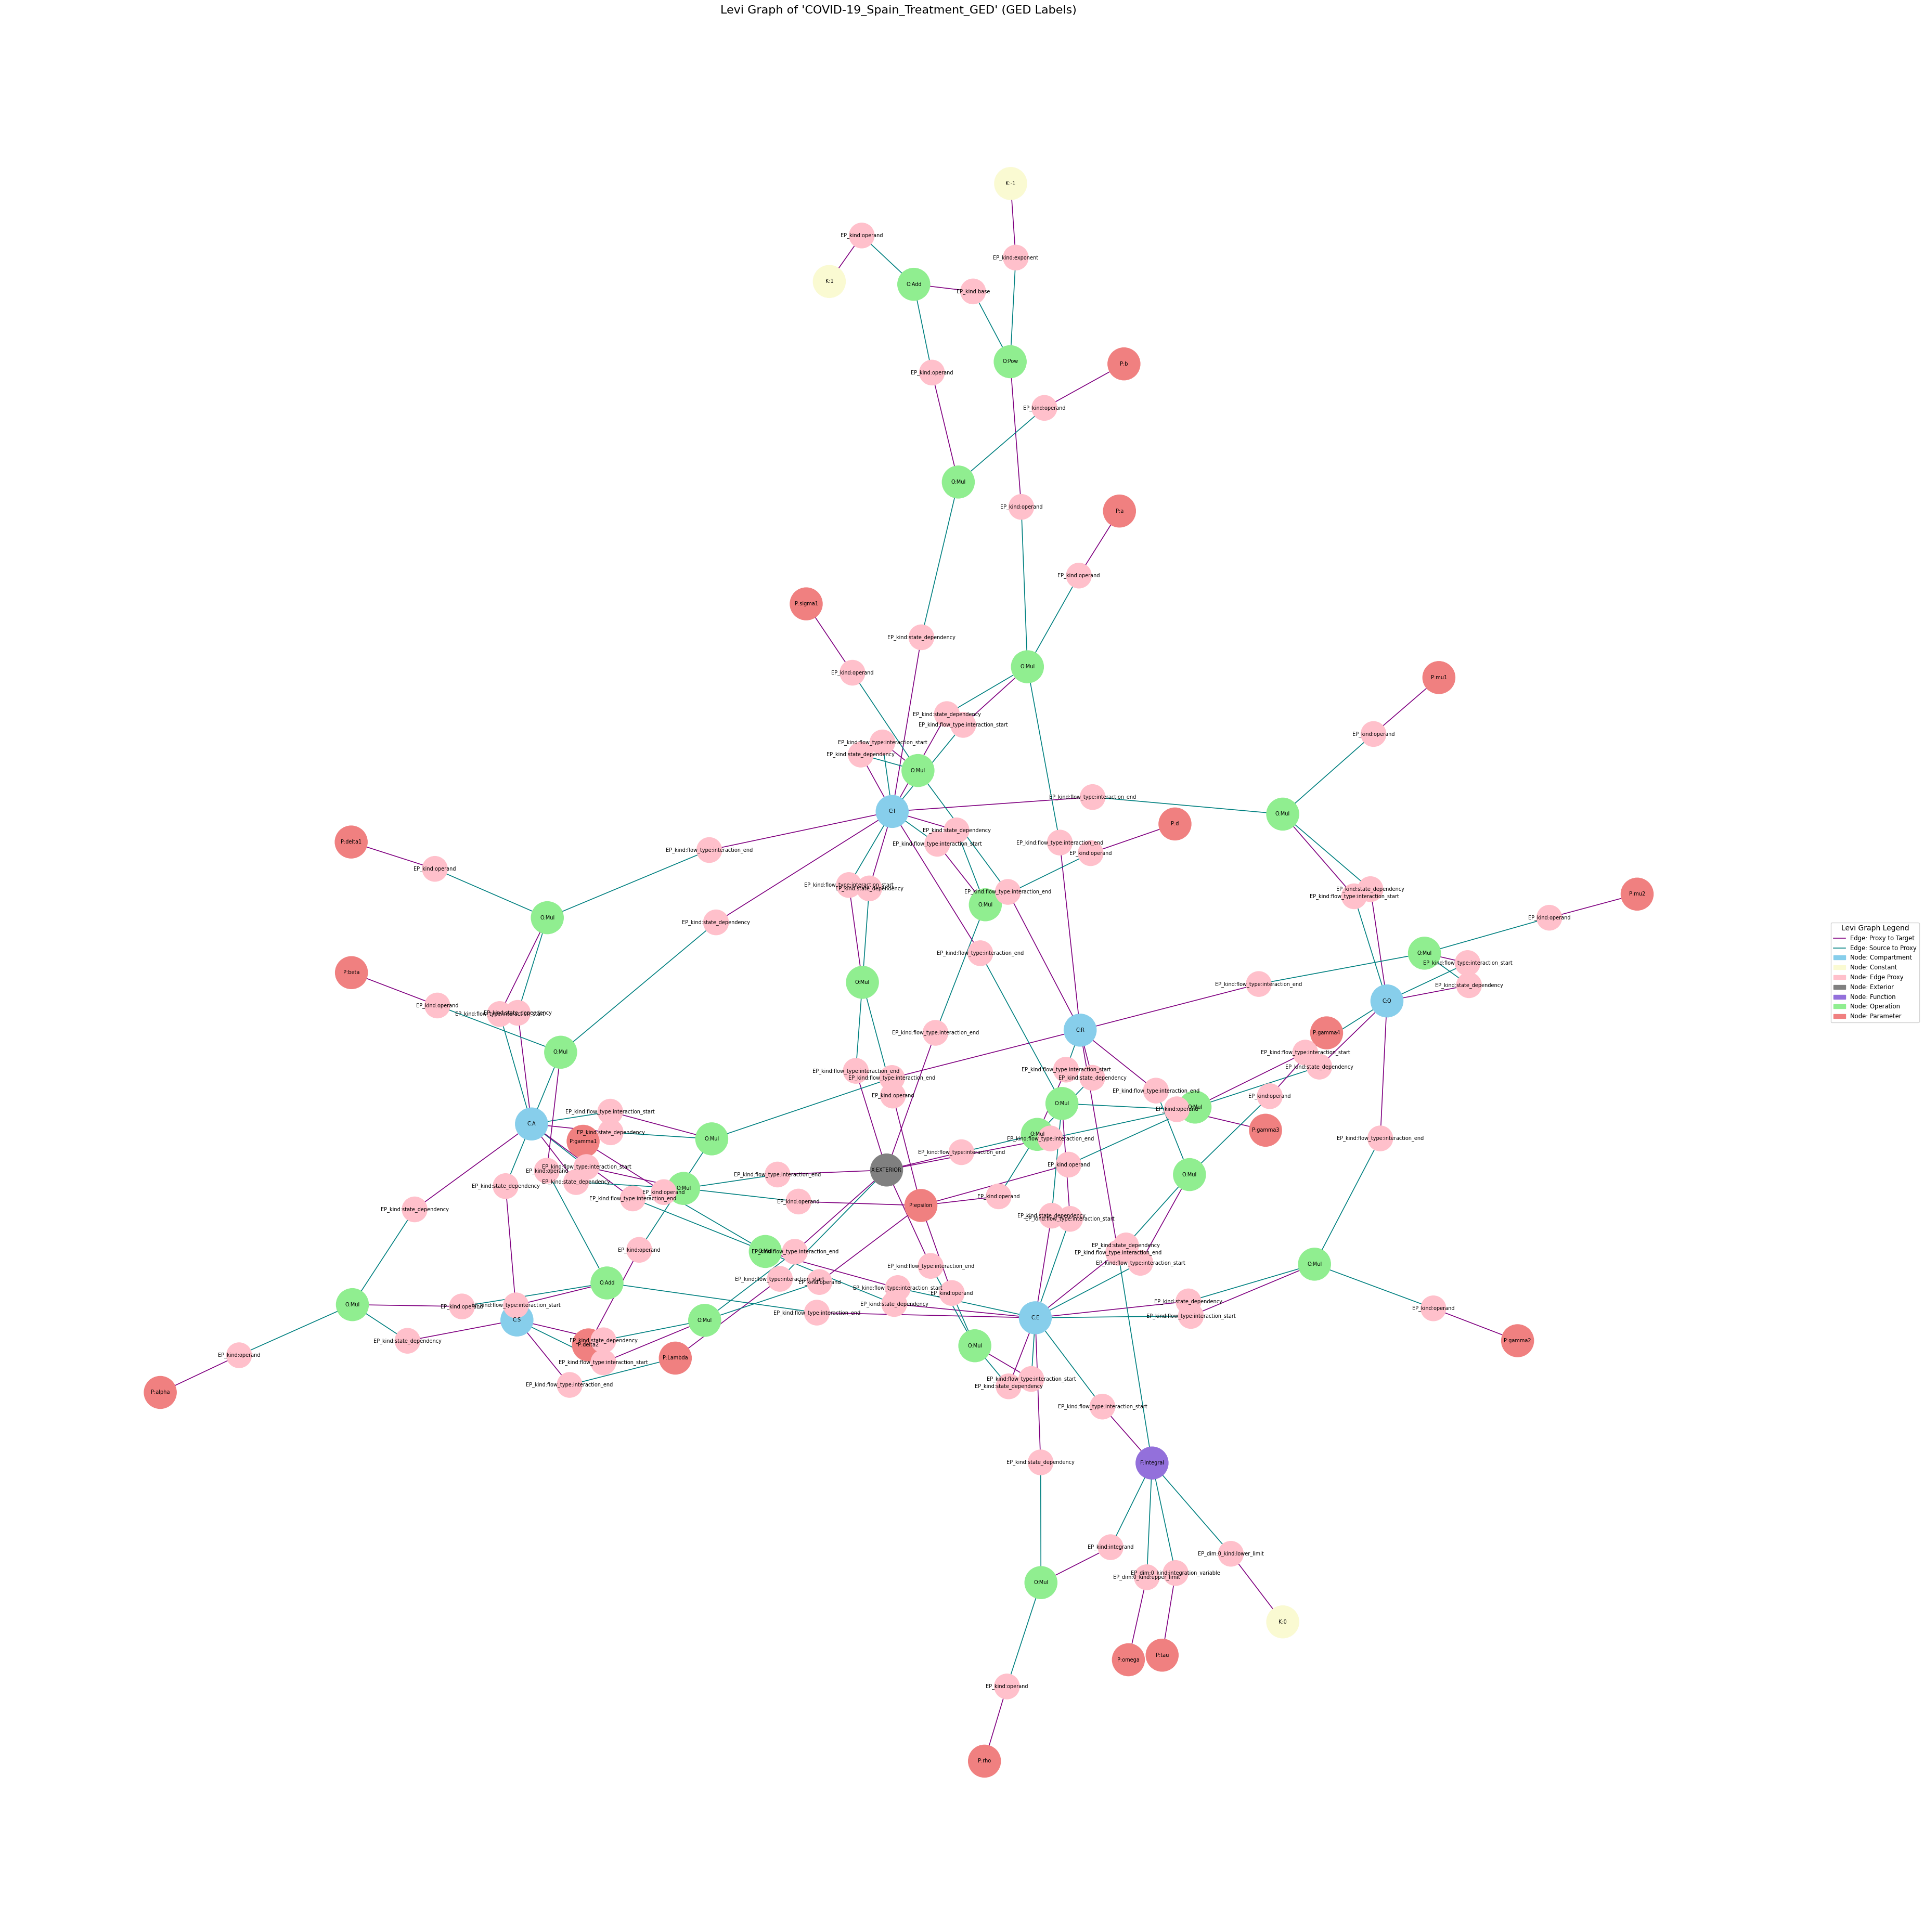

In [9]:
from __future__ import annotations

import itertools
from dataclasses import dataclass, field
from enum import Enum, auto
from typing import Any, Dict, Iterable, List, Optional, Set, Tuple, Callable # Added Callable

import networkx as nx
import sympy as sp
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

try:
    import pydot
    from networkx.drawing.nx_pydot import graphviz_layout
    HAS_PYDOT = True
except ImportError:
    HAS_PYDOT = False

import numpy as np
if not hasattr(np, 'alltrue'): # Shim for older numpy versions
    setattr(np, 'alltrue', np.all)


class NodeRole(Enum):
    COMPARTMENT = auto()
    EXTERIOR = auto()
    EXPR_OP = auto()
    EXPR_FUNCTION = auto()
    EXPR_SYMBOL = auto()
    EXPR_CONSTANT = auto()
    EDGE_PROXY = auto()

    def prefix(self) -> str:
        return {
            NodeRole.COMPARTMENT: "C",
            NodeRole.EXTERIOR: "X",
            NodeRole.EXPR_OP: "O",
            NodeRole.EXPR_FUNCTION: "F",
            NodeRole.EXPR_SYMBOL: "S", # General symbol, though P: U: are used for specific labels.
            NodeRole.EXPR_CONSTANT: "K",
            NodeRole.EDGE_PROXY: "EP",
        }[self]

class InteractionType(Enum):
    FLOW = "flow"

@dataclass
class NodeData:
    role: NodeRole
    label: str
    raw_label: str
    sympy_obj: Optional[sp.Basic] = None
    attrs: Dict[str, Any] = field(default_factory=dict)

    def as_dict(self) -> Dict[str, Any]:
        d = dict(role=self.role, label=self.label, raw_label=self.raw_label, **self.attrs)
        if self.sympy_obj is not None:
            d["sympy_str"] = str(self.sympy_obj)
        return d

@dataclass
class Interaction:
    source: str
    target: str
    int_type: InteractionType
    expr_root: str

StateVarSet = Set[str]
ParamSet = Set[str]

def _depends_on(expr: sp.Basic, state_vars: StateVarSet) -> bool:
    if not isinstance(expr, sp.Basic):
        return False
    return any(str(s) in state_vars for s in expr.free_symbols)

def _expand_state_dependent_products(expr: sp.Basic, state_vars: StateVarSet) -> sp.Basic:
    if not isinstance(expr, sp.Basic): return expr
    processed_args = [_expand_state_dependent_products(a, state_vars) for a in expr.args]
    try: expr = expr.func(*processed_args)
    except Exception:
        try: expr = expr.func(*expr.args)
        except Exception: return expr
    if not isinstance(expr, sp.Mul): return expr
    non_sums, sums_to_expand = [], []
    for arg in expr.args:
        if isinstance(arg, sp.Add) and _depends_on(arg, state_vars): sums_to_expand.append(arg)
        else: non_sums.append(arg)
    if not sums_to_expand: return expr
    prod_root = sp.Mul(*non_sums) if non_sums else sp.Integer(1)
    current = prod_root
    for s_expr_to_expand in sums_to_expand:
        current = sp.expand(current * s_expr_to_expand)
        current = _expand_state_dependent_products(current, state_vars)
    return current

def _flatten_add(expr: sp.Basic) -> sp.Basic:
    if not isinstance(expr, sp.Basic) or not expr.args: return expr
    processed_args = [_flatten_add(a) for a in expr.args]
    if not isinstance(expr, sp.Add):
        try:
            if any(pa is not oa for pa, oa in zip(processed_args, expr.args)):
                return expr.func(*processed_args)
            return expr
        except Exception: return expr
    flat_terms = []
    made_change_at_this_level = False
    for arg in processed_args:
        if isinstance(arg, sp.Add):
            flat_terms.extend(arg.args)
            made_change_at_this_level = True
        else:
            flat_terms.append(arg)
    children_changed = any(pa is not oa for pa, oa in zip(processed_args, expr.args))
    if made_change_at_this_level or children_changed:
        return sp.Add(*flat_terms, evaluate=False)
    return expr

def canonicalize_expression(expr: sp.Basic,
                            state_vars: StateVarSet,
                            params: ParamSet,
                            level: str = "basic") -> sp.Basic:
    if not isinstance(expr, sp.Basic): return expr
    try: e_expanded = _expand_state_dependent_products(expr, state_vars)
    except Exception as exp_e:
        print(f"Warning: _expand_state_dependent_products failed for {expr}: {exp_e}. Using original expression for next steps.")
        e_expanded = expr
    try: e_flattened = _flatten_add(e_expanded)
    except Exception as flat_e:
        print(f"Warning: _flatten_add failed for {e_expanded}: {flat_e}. Using result from expansion for next steps.")
        e_flattened = e_expanded
    original_for_simplify = e_flattened
    simplified_expr = e_flattened
    if level == "basic":
        try:
            e_cancel = sp.cancel(original_for_simplify)
            if e_cancel != original_for_simplify: simplified_expr = e_cancel
            else: simplified_expr = sp.simplify(original_for_simplify)
        except Exception as e_simp:
            print(f"Warning: Basic simplification (cancel/simplify) failed for {original_for_simplify}: {e_simp}. Using pre-simplification form.")
            simplified_expr = original_for_simplify
    elif level == "full":
        try: simplified_expr = sp.simplify(original_for_simplify)
        except Exception as e_full:
            print(f"Warning: Full simplification failed for {original_for_simplify}: {e_full}. Using pre-simplification form.")
            simplified_expr = original_for_simplify
    elif level == "ratsimp":
         try: simplified_expr = sp.ratsimp(original_for_simplify)
         except Exception as e_rat:
            print(f"Warning: Rational simplification (ratsimp) failed for {original_for_simplify}: {e_rat}. Using pre-simplification form.")
            simplified_expr = original_for_simplify
    elif level == "none": simplified_expr = original_for_simplify
    else: raise ValueError(f"Unknown simplification level: {level}")
    return simplified_expr

class EpiModelGraph:
    EXTERIOR_NODE_LABEL = "EXTERIOR"
    def __init__(self, name: str, state_vars: Iterable[str], params: Iterable[str]):
        self.name = name
        _state_vars_set = set(state_vars)
        if self.EXTERIOR_NODE_LABEL in _state_vars_set:
            raise ValueError(f"State variable name '{self.EXTERIOR_NODE_LABEL}' is reserved.")
        self.state_vars: StateVarSet = _state_vars_set
        self.params: ParamSet = set(params)
        self.g: nx.DiGraph = nx.DiGraph(name=name)
        self._ids = itertools.count()
        self._node_cache: Dict[Tuple[NodeRole, str], str] = {}
        self._shared_param_symbol_node_cache: Dict[sp.Symbol, str] = {}
        self._shared_constant_node_cache: Dict[sp.Basic, str] = {}
        self.exterior_node_id = self._add_node(
            role=NodeRole.EXTERIOR,
            raw_label=self.EXTERIOR_NODE_LABEL,
            label=f"{NodeRole.EXTERIOR.prefix()}:{self.EXTERIOR_NODE_LABEL}",
            always_create_new=False
        )
        for comp_name in self.state_vars:
            self._add_node(role=NodeRole.COMPARTMENT,
                           raw_label=comp_name,
                           label=f"{NodeRole.COMPARTMENT.prefix()}:{comp_name}",
                           always_create_new=False)

    def _new_id(self, role: NodeRole, raw_label_str: str) -> str:
        raw_simple = "".join(c if c.isalnum() else '_' for c in raw_label_str)[:15]
        return f"{role.prefix()}_{raw_simple}_{next(self._ids)}"

    def _add_node(self, *, role: NodeRole, raw_label: str, label: Optional[str] = None,
                  sympy_obj: Optional[sp.Basic] = None, always_create_new: bool = False, **attrs) -> str:
        cache_key = (role, raw_label)
        if not always_create_new and role in (NodeRole.COMPARTMENT, NodeRole.EXTERIOR):
            if cache_key in self._node_cache: return self._node_cache[cache_key]
        display_label = label if label is not None else f"{role.prefix()}:{raw_label}"
        nid = self._new_id(role, raw_label)
        node_data_obj = NodeData(role=role, label=display_label, raw_label=raw_label, sympy_obj=sympy_obj, attrs=attrs)
        self.g.add_node(nid, **node_data_obj.as_dict())
        if not always_create_new and role in (NodeRole.COMPARTMENT, NodeRole.EXTERIOR):
             self._node_cache[cache_key] = nid
        return nid

    def add_compartment(self, name: str, **attrs) -> str:
        if name == self.EXTERIOR_NODE_LABEL:
            raise ValueError(f"Cannot add compartment with reserved name '{self.EXTERIOR_NODE_LABEL}'.")
        if name in self.state_vars:
             print(f"Warning: Compartment '{name}' already exists.")
             return self._get_node_id(NodeRole.COMPARTMENT, name)
        self.state_vars.add(name)
        nid = self._add_node(role=NodeRole.COMPARTMENT, raw_label=name,
                           label=f"{NodeRole.COMPARTMENT.prefix()}:{name}", always_create_new=False, **attrs)
        return nid

    def _get_node_id(self, role: NodeRole, raw_label_val: str) -> str:
        cache_key = (role, raw_label_val)
        if role in (NodeRole.COMPARTMENT, NodeRole.EXTERIOR):
            if cache_key not in self._node_cache:
                raise KeyError(f"Node with role '{role}' and raw label '{raw_label_val}' not found in main cache. Was it added?")
            return self._node_cache[cache_key]
        if role == NodeRole.EXPR_SYMBOL:
            for sym_obj, nid_val in self._shared_param_symbol_node_cache.items():
                if str(sym_obj) == raw_label_val: return nid_val
        raise KeyError(f"Node lookup for role '{role}' and raw_label '{raw_label_val}' is not straightforward.")

    def _lookup_source_target_node(self, comp_or_exterior_name: str) -> str:
        if comp_or_exterior_name == self.EXTERIOR_NODE_LABEL: return self.exterior_node_id
        elif comp_or_exterior_name in self.state_vars:
            return self._get_node_id(NodeRole.COMPARTMENT, comp_or_exterior_name)
        else:
            raise ValueError(f"Unknown source/target '{comp_or_exterior_name}'. Must be a registered compartment or '{self.EXTERIOR_NODE_LABEL}'.")

    def add_interaction(self, source_name: str, target_name: str, expr: sp.Expr, canonical_level: str = "none") -> Interaction:
        int_type = InteractionType.FLOW
        src_nid = self._lookup_source_target_node(source_name)
        tgt_nid = self._lookup_source_target_node(target_name)
        if src_nid == tgt_nid:
             if source_name == self.EXTERIOR_NODE_LABEL: raise ValueError("Cannot add interaction from EXTERIOR to itself.")
             else: print(f"Warning: Adding interaction from compartment '{source_name}' to itself.")
        canon_expr = canonicalize_expression(expr, self.state_vars, self.params, level=canonical_level)
        expr_root_nid = self._expr_to_subgraph(canon_expr)
        self.g.add_edge(src_nid, expr_root_nid, kind=int_type.value, type="interaction_start")
        self.g.add_edge(expr_root_nid, tgt_nid, kind=int_type.value, type="interaction_end")
        return Interaction(source=source_name, target=target_name, int_type=int_type, expr_root=expr_root_nid)

    def _add_or_update_edge(self, u_node: str, v_node: str, **attrs_to_set: Any) -> None:
        if not self.g.has_edge(u_node, v_node):
            self.g.add_edge(u_node, v_node, **attrs_to_set)
        else:
            edge_data = self.g.edges[u_node, v_node]
            for key, new_value in attrs_to_set.items():
                if edge_data.get(key) != new_value:
                    if key in edge_data:
                        print(f"Warning: Overwriting edge attribute '{key}' for edge ({u_node}, {v_node}). Old: {edge_data[key]}, New: {new_value}")
                    edge_data[key] = new_value

    def _process_non_sympy_object(self, e_obj: Any, local_expr_node_cache: Dict[Any, str]) -> Tuple[str, bool]:
        try: hash(e_obj); cache_key = e_obj
        except TypeError: cache_key = repr(e_obj)
        if cache_key in local_expr_node_cache: return local_expr_node_cache[cache_key], False
        raw_label_str = str(e_obj)
        print(f"Warning: Non-Sympy object '{raw_label_str}' (type: {type(e_obj).__name__}) encountered. Treating as a Constant.")
        nid = self._add_node(role=NodeRole.EXPR_CONSTANT,
                             raw_label=f"NonSympy_{type(e_obj).__name__}_{raw_label_str}",
                             label=f"K:NonSympy_{type(e_obj).__name__}", sympy_obj=None, always_create_new=True)
        local_expr_node_cache[cache_key] = nid
        return nid, False

    def _process_sympy_symbol(self, e_sym: sp.Symbol, local_expr_node_cache: Dict[sp.Basic, str]) -> Tuple[str, bool]:
        raw_label_str = str(e_sym)
        if raw_label_str in self.state_vars:
            comp_nid = self._get_node_id(NodeRole.COMPARTMENT, raw_label_str)
            return comp_nid, True
        if raw_label_str in self.params:
            if e_sym in self._shared_param_symbol_node_cache:
                param_nid = self._shared_param_symbol_node_cache[e_sym]
                local_expr_node_cache[e_sym] = param_nid
                return param_nid, False
            nid = self._add_node(role=NodeRole.EXPR_SYMBOL, raw_label=raw_label_str, label=f"P:{raw_label_str}",
                                 sympy_obj=e_sym, always_create_new=False, attrs={'symbol_type': 'param'})
            self._shared_param_symbol_node_cache[e_sym] = nid
            local_expr_node_cache[e_sym] = nid
            return nid, False
        if e_sym in local_expr_node_cache: return local_expr_node_cache[e_sym], False
        symbol_type_attr = 'unknown'
        nid = self._add_node(role=NodeRole.EXPR_SYMBOL, raw_label=raw_label_str, label=f"U:{raw_label_str}",
                             sympy_obj=e_sym, always_create_new=True, attrs={'symbol_type': symbol_type_attr})
        local_expr_node_cache[e_sym] = nid
        return nid, False

    def _process_sympy_constant(self, e_const: sp.Number | sp.NumberSymbol, local_expr_node_cache: Dict[sp.Basic, str]) -> Tuple[str, bool]:
        if e_const in self._shared_constant_node_cache:
            const_nid = self._shared_constant_node_cache[e_const]
            local_expr_node_cache[e_const] = const_nid
            return const_nid, False
        raw_label_str = str(e_const)
        nid = self._add_node(role=NodeRole.EXPR_CONSTANT, raw_label=raw_label_str, label=f"K:{raw_label_str}",
                             sympy_obj=e_const, always_create_new=False)
        self._shared_constant_node_cache[e_const] = nid
        local_expr_node_cache[e_const] = nid
        return nid, False

    def _process_sympy_integral(self, e_int: sp.Integral, local_expr_node_cache: Dict[sp.Basic, str], rec_func: Callable) -> Tuple[str, bool]:
        role_integral = NodeRole.EXPR_FUNCTION
        raw_label_integral = e_int.func.__name__
        node_label_integral = f"{role_integral.prefix()}:{raw_label_integral}"
        if e_int in local_expr_node_cache: return local_expr_node_cache[e_int], False
        nid = self._add_node(role=role_integral, raw_label=raw_label_integral, label=node_label_integral,
                             sympy_obj=e_int, always_create_new=True)
        local_expr_node_cache[e_int] = nid
        if e_int.args:
            integrand_expr = e_int.args[0]
            integrand_nid, _ = rec_func(integrand_expr)
            self._add_or_update_edge(nid, integrand_nid, kind="integrand", order=0)
        for dim_idx, limit_spec in enumerate(e_int.limits):
            limit_spec_arg_order = dim_idx
            is_python_tuple = isinstance(limit_spec, tuple)
            is_sympy_tuple = hasattr(sp, 'Tuple') and isinstance(limit_spec, sp.Tuple)
            if not (is_python_tuple or is_sympy_tuple) or not limit_spec:
                print(f"Warning: Integral {nid} (Expr: {e_int}) has an invalid limit spec: {limit_spec}. Skipping.")
                continue
            var_symbol = limit_spec[0]
            var_nid, _ = rec_func(var_symbol)
            self._add_or_update_edge(nid, var_nid, kind="integration_variable", order=limit_spec_arg_order, dim_index=dim_idx)
            if len(limit_spec) > 1 and limit_spec[1] is not None:
                lower_limit_expr = limit_spec[1]
                lower_nid, _ = rec_func(lower_limit_expr)
                self._add_or_update_edge(nid, lower_nid, kind="lower_limit", order=limit_spec_arg_order, dim_index=dim_idx)
            if len(limit_spec) > 2 and limit_spec[2] is not None:
                upper_limit_expr = limit_spec[2]
                upper_nid, _ = rec_func(upper_limit_expr)
                self._add_or_update_edge(nid, upper_nid, kind="upper_limit", order=limit_spec_arg_order, dim_index=dim_idx)
        return nid, False

    def _process_sympy_op_or_function(self, e_op_func: sp.Basic, local_expr_node_cache: Dict[sp.Basic, str], rec_func: Callable) -> Tuple[str, bool]:
        if e_op_func in local_expr_node_cache: return local_expr_node_cache[e_op_func], False
        raw_label_op_func = e_op_func.func.__name__
        node_label_op_func: str; role_op_func: NodeRole
        if issubclass(e_op_func.func, sp.Function):
            role_op_func = NodeRole.EXPR_FUNCTION; node_label_op_func = f"F:{raw_label_op_func}"
        else:
            role_op_func = NodeRole.EXPR_OP; node_label_op_func = f"O:{raw_label_op_func}"
        nid = self._add_node(role=role_op_func, raw_label=raw_label_op_func, label=node_label_op_func,
                             sympy_obj=e_op_func, always_create_new=True)
        local_expr_node_cache[e_op_func] = nid
        is_pow_op = isinstance(e_op_func, sp.Pow)
        for i, arg_expr in enumerate(e_op_func.args):
            child_nid, child_is_compartment = rec_func(arg_expr)
            edge_kind = "operand"
            if is_pow_op:
                if i == 0: edge_kind = "base"
                elif i == 1: edge_kind = "exponent"
                else: print(f"Warning: Pow operation {nid} has unexpected argument index {i}.")
            if child_is_compartment: edge_kind = "state_dependency"
            self._add_or_update_edge(nid, child_nid, kind=edge_kind, order=i)
        return nid, False

    def _expr_to_subgraph(self, expr: sp.Basic) -> str:
        local_expr_node_cache: Dict[sp.Basic, str] = {}
        memoized_nodes = {}
        def _recursive_processor(e_obj_to_process: sp.Basic) -> Tuple[str, bool]:
            if e_obj_to_process in memoized_nodes: return memoized_nodes[e_obj_to_process]
            result: Tuple[str, bool]
            if not isinstance(e_obj_to_process, sp.Basic):
                result = self._process_non_sympy_object(e_obj_to_process, local_expr_node_cache)
            elif isinstance(e_obj_to_process, sp.Symbol):
                result = self._process_sympy_symbol(e_obj_to_process, local_expr_node_cache)
            elif isinstance(e_obj_to_process, (sp.Number, sp.NumberSymbol)):
                result = self._process_sympy_constant(e_obj_to_process, local_expr_node_cache)
            elif isinstance(e_obj_to_process, sp.Integral):
                result = self._process_sympy_integral(e_obj_to_process, local_expr_node_cache, _recursive_processor)
            elif e_obj_to_process.args:
                result = self._process_sympy_op_or_function(e_obj_to_process, local_expr_node_cache, _recursive_processor)
            else:
                raw_label_unhandled = str(e_obj_to_process)
                print(f"Warning: Unhandled SymPy leaf expression type: {type(e_obj_to_process)} for '{raw_label_unhandled}'. Treating as generic Symbol.")
                nid_unhandled = self._add_node(role=NodeRole.EXPR_SYMBOL, raw_label=raw_label_unhandled, label=f"U:{raw_label_unhandled}",
                                     sympy_obj=e_obj_to_process, always_create_new=True, attrs={'symbol_type': 'unhandled_leaf'})
                local_expr_node_cache[e_obj_to_process] = nid_unhandled
                result = nid_unhandled, False
            memoized_nodes[e_obj_to_process] = result
            return result
        root_nid, _ = _recursive_processor(expr)
        return root_nid

    def to_networkx(self) -> nx.DiGraph: return self.g

    def to_undirected_levi_graph(self) -> nx.Graph:
        undirected_g = nx.Graph(name=f"undirected_levi_{self.name}")
        for node_id, node_data_dict in self.g.nodes(data=True):
            undirected_g.add_node(node_id, **node_data_dict)
        for u_orig, v_orig, original_edge_data_dict in self.g.edges(data=True):
            ep_raw_label = f"edge_from_{u_orig}_to_{v_orig}"
            ep_node_id = self._new_id(NodeRole.EDGE_PROXY, ep_raw_label)
            ep_label_parts = []
            if 'kind' in original_edge_data_dict: ep_label_parts.append(f"kind:{original_edge_data_dict['kind']}")
            if 'type' in original_edge_data_dict: ep_label_parts.append(f"type:{original_edge_data_dict['type']}")
            if 'order' in original_edge_data_dict: ep_label_parts.append(f"order:{original_edge_data_dict['order']}")
            if 'dim_index' in original_edge_data_dict: ep_label_parts.append(f"dim:{original_edge_data_dict['dim_index']}")
            descriptive_ep_label = f"{NodeRole.EDGE_PROXY.prefix()}:" + (";".join(ep_label_parts) if ep_label_parts else "edge")
            ep_node_attrs = {'role': NodeRole.EDGE_PROXY, 'label': descriptive_ep_label, 'raw_label': ep_raw_label,
                             'original_attributes': dict(original_edge_data_dict),
                             'original_source_id': u_orig, 'original_target_id': v_orig}
            undirected_g.add_node(ep_node_id, **ep_node_attrs)
            undirected_g.add_edge(u_orig, ep_node_id, link_type="source_to_proxy")
            undirected_g.add_edge(ep_node_id, v_orig, link_type="proxy_to_target")
        return undirected_g

    def get_levi_graph_with_ged_labels(self) -> nx.Graph:
        levi_graph = self.to_undirected_levi_graph()
        for node_id, data in levi_graph.nodes(data=True):
            role = data['role']; ged_label_str: str
            if role != NodeRole.EDGE_PROXY: ged_label_str = data['label']
            else:
                original_attrs = data.get('original_attributes', {}); label_components = []
                kind_val = original_attrs.get('kind')
                if kind_val == "operand":
                    original_source_node_id = data.get('original_source_id')
                    is_generic_func_operand = False
                    if original_source_node_id:
                        original_source_node_data = self.g.nodes.get(original_source_node_id, {})
                        original_source_role = original_source_node_data.get('role')
                        original_source_sympy_obj = original_source_node_data.get('sympy_obj') # Fetch Sympy Object
                        if original_source_role == NodeRole.EXPR_FUNCTION and original_source_sympy_obj:
                             # Check if it's a user-defined/generic sp.Function, not specific SymPy classes like Integral etc.
                             # that have their own kinds or are commutative (Add, Mul).
                            if not isinstance(original_source_sympy_obj, (sp.Integral, sp.Pow, sp.Add, sp.Mul)):
                                is_generic_func_operand = True
                    if is_generic_func_operand and 'order' in original_attrs:
                        label_components.append(f"kind:{kind_val}_{original_attrs['order']}")
                    else: label_components.append(f"kind:{kind_val}")
                elif kind_val: label_components.append(f"kind:{kind_val}")
                if 'type' in original_attrs: label_components.append(f"type:{original_attrs['type']}")
                if 'dim_index' in original_attrs and kind_val in ("integration_variable", "lower_limit", "upper_limit", "integrand"): # Added integrand
                    label_components.append(f"dim:{original_attrs['dim_index']}")
                label_components.sort()
                ged_label_str = f"EP_" + "_".join(label_components) if label_components else "EP_edge"
            levi_graph.nodes[node_id]['ged_label'] = ged_label_str
        return levi_graph

    def summary(self) -> str:
        comps = sorted([d["raw_label"] for _, d in self.g.nodes(data=True) if d["role"] == NodeRole.COMPARTMENT])
        num_interactions = 0; num_expr_nodes = 0; num_comp_nodes = len(comps)
        num_ext_nodes = 0; num_param_symbol_nodes = 0; num_const_nodes = 0
        for _, d_node in self.g.nodes(data=True):
            role = d_node.get("role")
            if role == NodeRole.EXTERIOR: num_ext_nodes += 1
            elif role == NodeRole.EXPR_SYMBOL and d_node.get('attrs', {}).get('symbol_type') == 'param': num_param_symbol_nodes +=1
            elif role == NodeRole.EXPR_CONSTANT: num_const_nodes +=1
            elif role in (NodeRole.EXPR_OP, NodeRole.EXPR_FUNCTION, NodeRole.EXPR_SYMBOL):
                if not (role == NodeRole.EXPR_SYMBOL and \
                        (d_node.get('attrs',{}).get('symbol_type') == 'param' or \
                         d_node.get('raw_label') in self.state_vars)):
                    num_expr_nodes +=1
        for _, _, d_edge in self.g.edges(data=True):
            if d_edge.get("type") == "interaction_start": num_interactions +=1
        summary_str = (f"EpiModelGraph(name={self.name!r})\n"
                       f"  Compartments ({num_comp_nodes}): {comps}\n"
                       f"  Exterior Nodes: {num_ext_nodes}\n"
                       f"  Shared Parameter Symbol Nodes (P:): {num_param_symbol_nodes}\n"
                       f"  Shared Constant Nodes (K:): {num_const_nodes}\n"
                       f"  Other Expression Nodes (O:, F:, U:): {num_expr_nodes}\n"
                       f"  Interactions (Flows): {num_interactions}\n"
                       f"  Total Nodes in DiGraph: {self.g.number_of_nodes()}\n"
                       f"  Total Edges in DiGraph: {self.g.number_of_edges()}")
        return summary_str

def visualize_levi_graph(levi_graph: nx.Graph, title: str = "Levi Graph Visualization", layout_prog: str = 'neato', label_key:str = 'label'):
    if not levi_graph.nodes: print("Graph is empty, cannot visualize."); return
    fig, ax = plt.subplots(figsize=(max(15, levi_graph.number_of_nodes() * 0.3),
                                   max(12, levi_graph.number_of_nodes() * 0.25)))
    node_color_defs = {
        'Compartment': ('skyblue', NodeRole.COMPARTMENT), 'Exterior': ('grey', NodeRole.EXTERIOR),
        'Operation': ('lightgreen', NodeRole.EXPR_OP), 'Function': ('mediumpurple', NodeRole.EXPR_FUNCTION),
        'Parameter': ('lightcoral', NodeRole.EXPR_SYMBOL, 'param'),
        'Unknown Symbol': ('orange', NodeRole.EXPR_SYMBOL, 'unknown'),
        'Constant': ('lightgoldenrodyellow', NodeRole.EXPR_CONSTANT),
        'Unhandled Symbol': ('yellow', NodeRole.EXPR_SYMBOL, 'unhandled'),
        'Edge Proxy': ('pink', NodeRole.EDGE_PROXY)}
    node_colors = []; node_sizes = []; node_legend_handles = []; seen_node_legend_labels = set()
    base_node_size = 2000
    for n_id, data in levi_graph.nodes(data=True):
        role = data.get('role')
        if not isinstance(role, NodeRole) and isinstance(role, str):
            try: role = NodeRole[role.split('.')[-1].upper()]
            except KeyError: role = NodeRole.EXTERIOR
        elif not isinstance(role, NodeRole): role = NodeRole.EXTERIOR
        symbol_type = data.get('attrs', {}).get('symbol_type', data.get('symbol_type'))
        current_node_color = 'white'; current_node_size = base_node_size
        node_type_id_key = role
        if role == NodeRole.EXPR_SYMBOL and symbol_type: node_type_id_key = (role, symbol_type)
        elif role == NodeRole.EDGE_PROXY: current_node_size = base_node_size * 0.6
        matched_legend_label_for_node = None
        for legend_label_str, (def_color, def_role, *def_symbol_type_opt) in node_color_defs.items():
            def_st = def_symbol_type_opt[0] if def_symbol_type_opt else None
            current_def_key = def_role
            if def_st: current_def_key = (def_role, def_st)
            if node_type_id_key == current_def_key:
                current_node_color = def_color; matched_legend_label_for_node = legend_label_str; break
        if matched_legend_label_for_node and matched_legend_label_for_node not in seen_node_legend_labels:
            node_legend_handles.append(mpatches.Patch(color=current_node_color, label=f"Node: {matched_legend_label_for_node}"))
            seen_node_legend_labels.add(matched_legend_label_for_node)
        elif not matched_legend_label_for_node and role and role.name not in seen_node_legend_labels:
            default_role_label_str = f"Node: {role.name} (Default)"
            node_legend_handles.append(mpatches.Patch(color=current_node_color, label=default_role_label_str))
            seen_node_legend_labels.add(role.name)
        node_colors.append(current_node_color); node_sizes.append(current_node_size)
    display_labels = {n_id: data.get(label_key, data.get('label', str(n_id)))
                      for n_id, data in levi_graph.nodes(data=True)}
    pos = None
    layout_iterations = max(70, int(np.log(max(2,levi_graph.number_of_nodes()))*30))
    spring_k = 2.5 / np.sqrt(max(1, levi_graph.number_of_nodes()))
    if HAS_PYDOT:
        try:
            g_for_layout = levi_graph.copy()
            for n_id_layout, node_data_layout in g_for_layout.nodes(data=True):
                lbl_val = str(node_data_layout.get(label_key, node_data_layout.get('label', '')))
                if ':' in lbl_val or ';' in lbl_val or ' ' in lbl_val:
                     g_for_layout.nodes[n_id_layout]['label'] = f'"{lbl_val}"'
                else: g_for_layout.nodes[n_id_layout]['label'] = lbl_val
            pos = graphviz_layout(g_for_layout, prog=layout_prog)
        except Exception as e:
            print(f"Warning: Pydot layout '{layout_prog}' failed ({e}). Using NetworkX spring_layout.")
            pos = nx.spring_layout(levi_graph, k=spring_k, iterations=layout_iterations, seed=42, scale=3.0)
    else:
        print("Info: pydot not found. Using NetworkX spring_layout (can be slow for large graphs).")
        pos = nx.spring_layout(levi_graph, k=spring_k, iterations=layout_iterations, seed=42, scale=3.0)
    edge_color_defs = {
        'Source to Proxy': ('teal', 'solid', 1.2, 'source_to_proxy'),
        'Proxy to Target': ('purple', 'solid', 1.2, 'proxy_to_target'),
        'Other Link': ('darkgrey', 'dotted', 0.8, None)}
    edge_colors = []; edge_styles = []; edge_widths = []; edge_legend_handles = []; seen_edge_legend_labels = set()
    for u_node, v_node, edge_data_dict in levi_graph.edges(data=True):
        link_type_val = edge_data_dict.get('link_type')
        current_edge_color, current_edge_style, current_edge_width = edge_color_defs['Other Link'][:3]
        matched_legend_label_for_edge = 'Other Link'
        for legend_label_str, (def_color, def_style, def_width, def_link_type) in edge_color_defs.items():
            if def_link_type == link_type_val:
                current_edge_color,current_edge_style,current_edge_width = def_color,def_style,def_width
                matched_legend_label_for_edge = legend_label_str; break
        edge_colors.append(current_edge_color); edge_styles.append(current_edge_style); edge_widths.append(current_edge_width)
        if matched_legend_label_for_edge not in seen_edge_legend_labels:
            edge_legend_handles.append(mlines.Line2D([], [], color=current_edge_color, linestyle=current_edge_style,
                                                    linewidth=current_edge_width, label=f"Edge: {matched_legend_label_for_edge}"))
            seen_edge_legend_labels.add(matched_legend_label_for_edge)
    nx.draw(levi_graph, pos, ax=ax, labels=display_labels, with_labels=True,
            node_color=node_colors, node_size=node_sizes, edge_color=edge_colors, style=edge_styles, width=edge_widths,
            font_size=max(6, 10 - levi_graph.number_of_nodes() // 40), font_weight='normal', arrows=False)
    all_handles = sorted(node_legend_handles + edge_legend_handles, key=lambda x: x.get_label())
    if all_handles:
        ax.legend(handles=all_handles, loc='center left', bbox_to_anchor=(1.02, 0.5),
                  fontsize='small', title="Levi Graph Legend", framealpha=0.9)
    ax.set_title(title, fontsize=16); ax.axis('off')
    plt.tight_layout(rect=[0, 0, 0.83, 1]); plt.show()

# --- Main Example Block (COVID-19 Spain Treatment Model) ---
if __name__ == "__main__":
    state_vars_covid = ['S', 'E', 'A', 'Q', 'I', 'R']
    params_covid = [
        'Lambda', 'alpha', 'beta',
        'gamma1', 'gamma2', 'gamma3',
        'delta1', 'mu1',
        'gamma4', 'delta2', 'mu2', 'sigma1',
        'a', 'b',
        'd',
        'epsilon',
        'rho', 'omega', 'tau' # Added tau here explicitly as it's used
    ]

    # Define SymPy symbols
    S, E, A, Q, I, R, Lambda, alpha, beta, gamma1, gamma2, gamma3, \
    delta1, mu1, gamma4, delta2, mu2, sigma1, a, b, d, epsilon, rho, omega, tau \
        = sp.symbols(state_vars_covid + params_covid)

    # Create the EpiModelGraph instance
    covid_model = EpiModelGraph(
        name="COVID-19_Spain_Treatment_GED",
        state_vars=state_vars_covid,
        params=params_covid
    )

    # Add interactions as defined in your example
    covid_model.add_interaction(EpiModelGraph.EXTERIOR_NODE_LABEL, 'S', Lambda)
    infection_expr = (alpha * A + beta * I) * S
    covid_model.add_interaction('S', 'E', infection_expr)
    covid_model.add_interaction('S', EpiModelGraph.EXTERIOR_NODE_LABEL, epsilon * S)
    covid_model.add_interaction('E', EpiModelGraph.EXTERIOR_NODE_LABEL, epsilon * E)
    covid_model.add_interaction('A', EpiModelGraph.EXTERIOR_NODE_LABEL, epsilon * A)
    covid_model.add_interaction('Q', EpiModelGraph.EXTERIOR_NODE_LABEL, epsilon * Q)
    covid_model.add_interaction('I', EpiModelGraph.EXTERIOR_NODE_LABEL, epsilon * I)
    covid_model.add_interaction('R', EpiModelGraph.EXTERIOR_NODE_LABEL, epsilon * R)
    covid_model.add_interaction('E', 'A', gamma1 * E)
    covid_model.add_interaction('E', 'Q', gamma2 * E)
    covid_model.add_interaction('E', 'I', gamma3 * E)
    covid_model.add_interaction('E', 'R', gamma4 * E)
    covid_model.add_interaction('A', 'I', delta1 * A)
    covid_model.add_interaction('A', 'R', delta2 * A)
    covid_model.add_interaction('Q', 'I', mu1 * Q)
    covid_model.add_interaction('Q', 'R', mu2 * Q)
    covid_model.add_interaction('I', 'R', sigma1 * I)
    
    treatment_expr = (a / (sp.Integer(1) + b * I)) * I # Using sp.Integer(1) for clarity
    covid_model.add_interaction('I', 'R', treatment_expr)
    
    covid_model.add_interaction('I', EpiModelGraph.EXTERIOR_NODE_LABEL, d * I)

    # Interaction with an Integral
    # tau was already defined with other symbols
    integral_expr_covid = sp.Integral(rho * E, (tau, 0, omega))
    covid_model.add_interaction('E', 'R', integral_expr_covid, canonical_level="none") # Specify canonical_level if needed

    print("--- Original Directed COVID-19 Model Summary ---")
    print(covid_model.summary())
    print("\n")

    # Get the Levi graph with GED labels
    levi_covid_model_ged = covid_model.get_levi_graph_with_ged_labels()

    print("--- Undirected Levi Graph for COVID-19 Model with GED Labels ---")
    print(f"Name: {levi_covid_model_ged.name}")
    print(f"Number of nodes: {levi_covid_model_ged.number_of_nodes()}")
    print(f"Number of edges: {levi_covid_model_ged.number_of_edges()}")

    print("\nExample nodes in COVID-19 Levi graph with GED labels:")
    original_nodes_count_covid = 0
    edge_proxy_nodes_count_covid = 0
    display_limit_covid = 7 # Show a few more of each type for this larger graph

    for i, (node_id, data) in enumerate(levi_covid_model_ged.nodes(data=True)):
        if data.get('role') == NodeRole.EDGE_PROXY:
            edge_proxy_nodes_count_covid += 1
            if edge_proxy_nodes_count_covid <= display_limit_covid:
                 print(f"  EP Node: ID={node_id}, GED Label='{data.get('ged_label')}', OrigLabel='{data.get('label')}'")
        else:
            original_nodes_count_covid += 1
            # Show a few original nodes, not just exterior
            if original_nodes_count_covid <= display_limit_covid :
                print(f"  Orig Node: ID={node_id}, Role={data.get('role')}, GED Label='{data.get('ged_label')}'")

    print(f"\nTotal original nodes represented in COVID Levi graph: {original_nodes_count_covid}")
    print(f"Total edge proxy nodes created in COVID Levi graph: {edge_proxy_nodes_count_covid}")
    print("\n")

    # Visualize using the 'ged_label'
    visualize_levi_graph(levi_covid_model_ged,
                         title=f"Levi Graph of '{covid_model.name}' (GED Labels)",
                         layout_prog='sfdp' if HAS_PYDOT else 'spring', # sfdp might be better for larger graphs
                         label_key='ged_label')

--- Original Directed COVID-19 Model Summary ---
EpiModelGraph(name='COVID-19_Spain_Treatment_GED')
  Compartments (6): ['A', 'E', 'I', 'Q', 'R', 'S']
  Exterior Nodes: 1
  Parameter Nodes (P:): 18
  Delay Term Nodes (D:): 0
  Integration Variable Nodes (IV:): 1
  Constant Nodes (K:): 3
  Other Expression Nodes (O:, F:, non-typed U:): 25
  Interactions (Flows): 20
  Total Nodes in DiGraph: 54
  Total Edges in DiGraph: 95


--- Undirected Levi Graph for COVID-19 Model with GED Labels ---
Name: undirected_levi_COVID-19_Spain_Treatment_GED
Number of nodes: 149
Number of edges: 190

Example nodes in COVID-19 Levi graph with GED labels:
  Orig Node: ID=X_EXTERIOR_0, Role=NodeRole.EXTERIOR, GED Label='X:EXTERIOR', Attrs=None
  Orig Node: ID=C_R_1, Role=NodeRole.COMPARTMENT, GED Label='C:R', Attrs=None
  Orig Node: ID=C_E_2, Role=NodeRole.COMPARTMENT, GED Label='C:E', Attrs=None
  Orig Node: ID=C_I_3, Role=NodeRole.COMPARTMENT, GED Label='C:I', Attrs=None
  Orig Node: ID=C_A_4, Role=NodeRole.

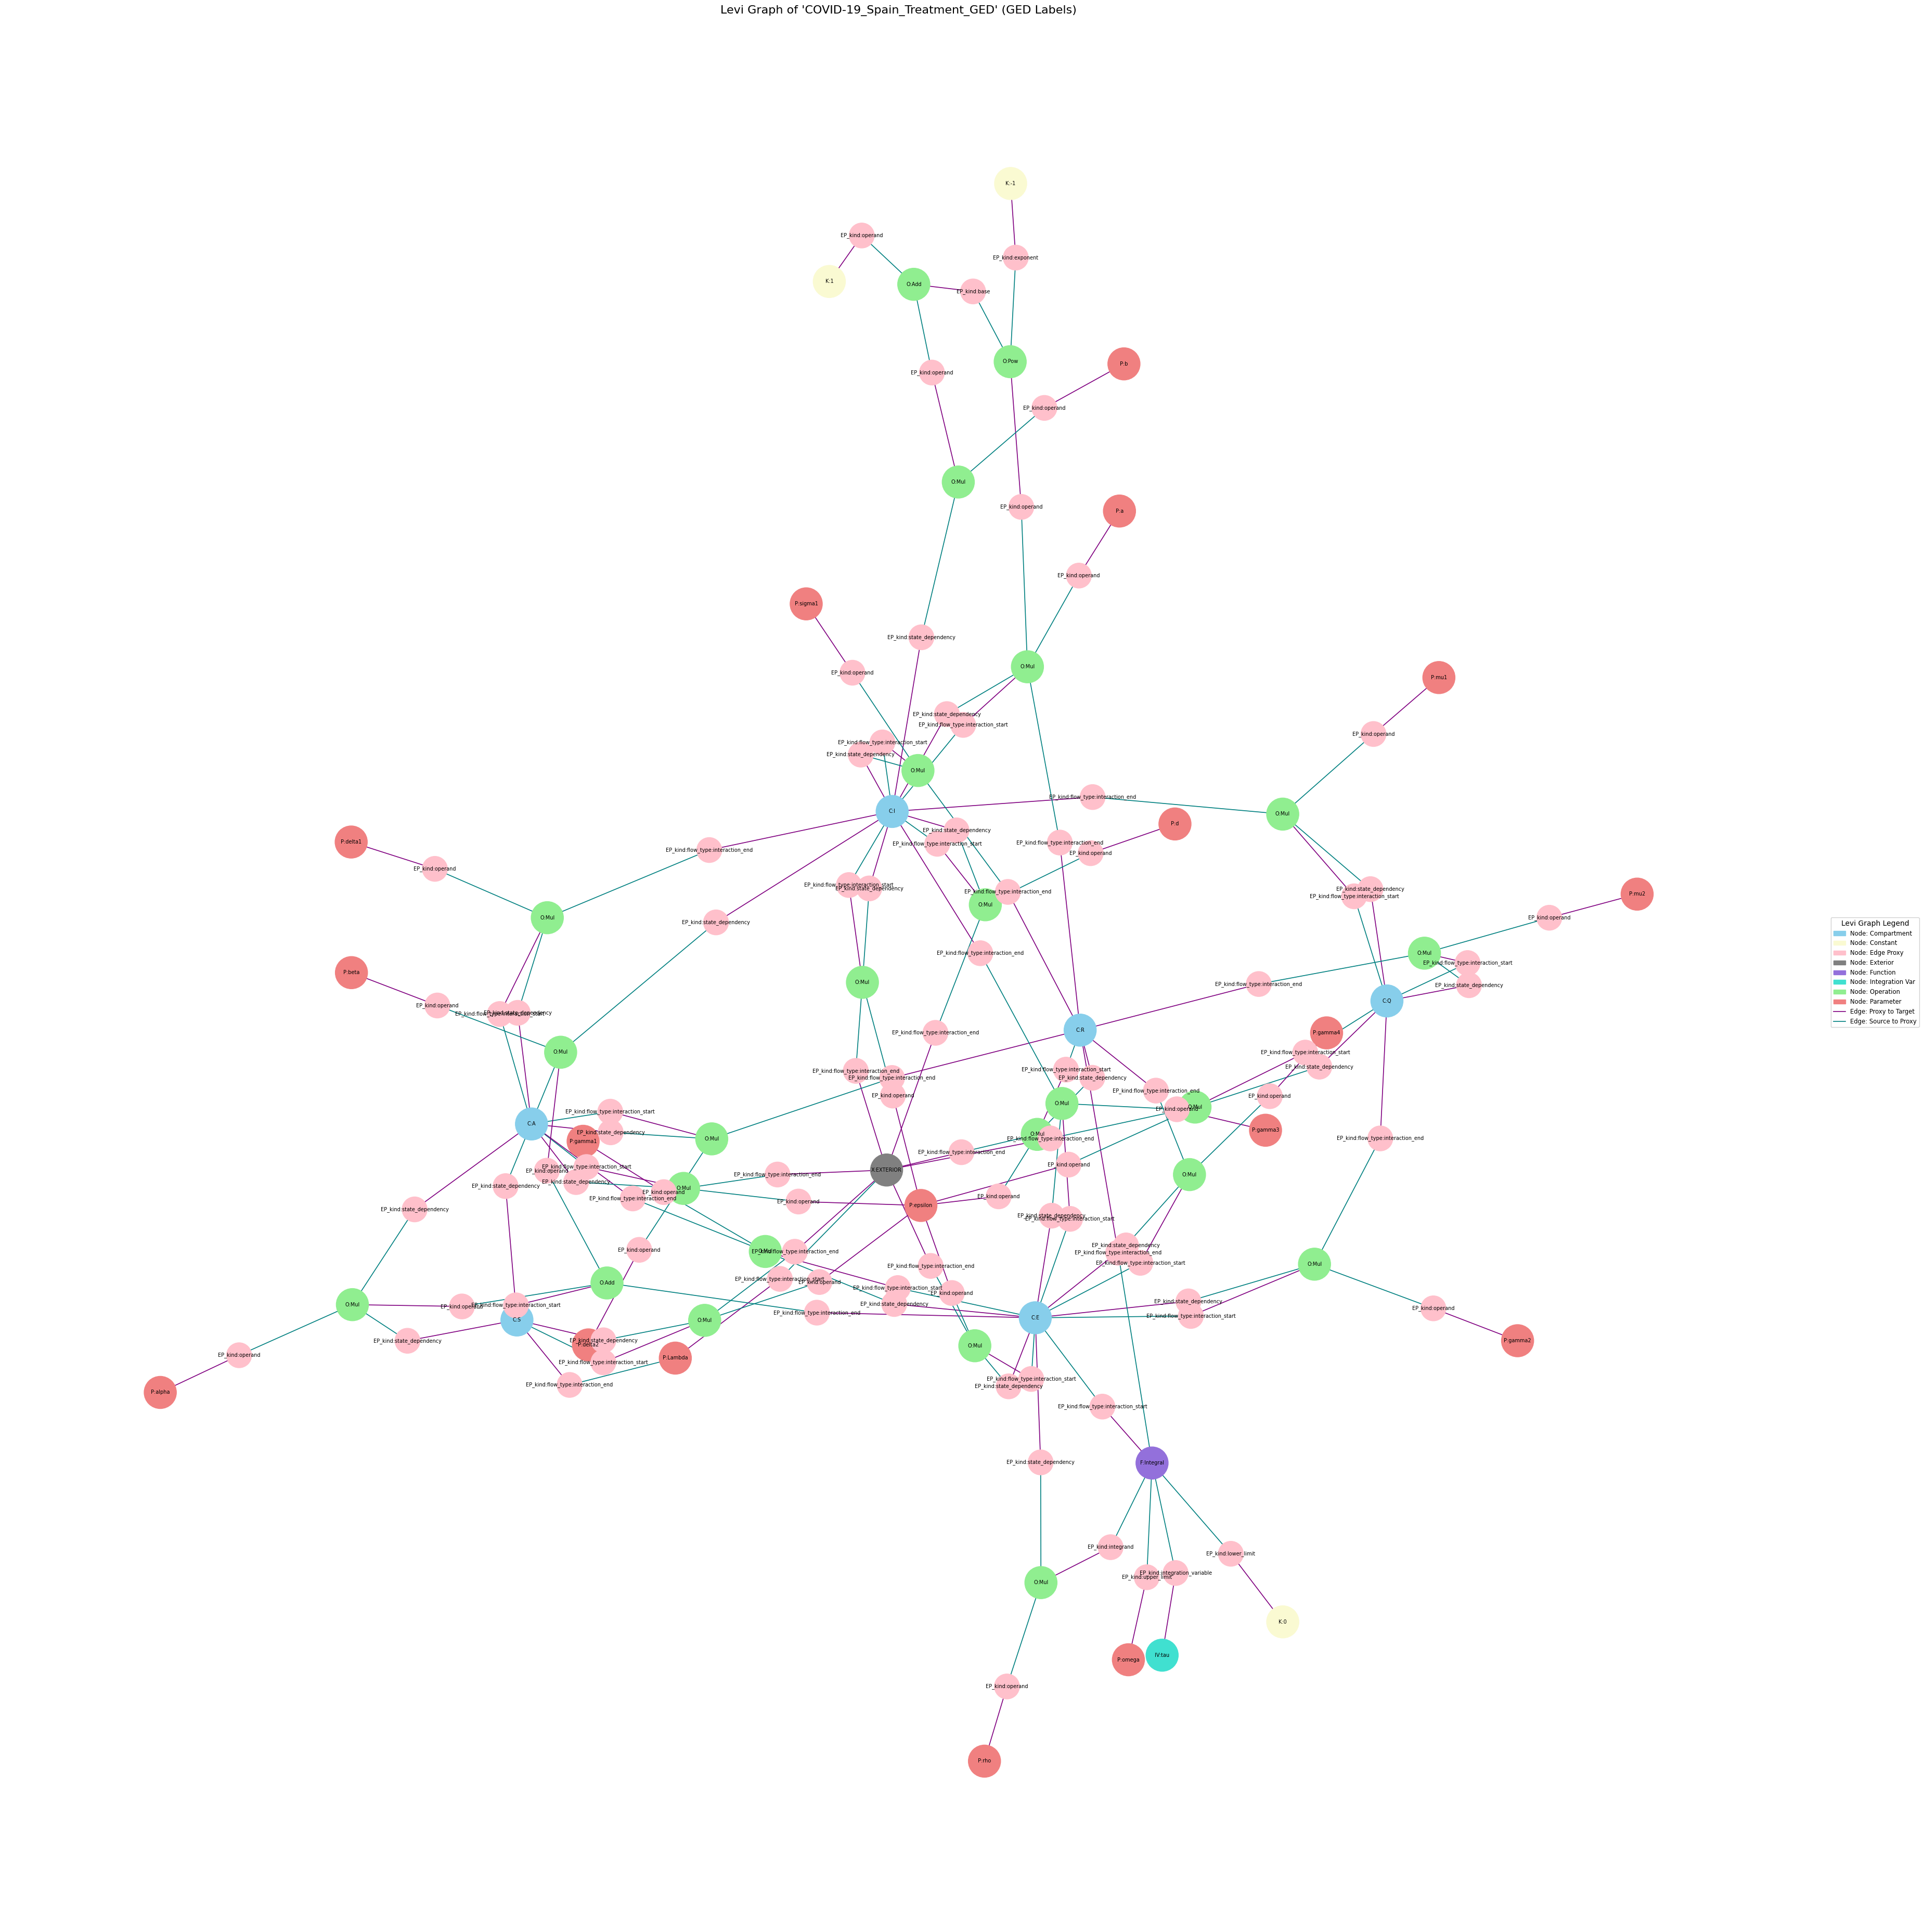

In [10]:
from __future__ import annotations

import itertools
from dataclasses import dataclass, field
from enum import Enum, auto
from typing import Any, Dict, Iterable, List, Optional, Set, Tuple, Callable

import networkx as nx
import sympy as sp
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

try:
    import pydot
    from networkx.drawing.nx_pydot import graphviz_layout
    HAS_PYDOT = True
except ImportError:
    HAS_PYDOT = False

import numpy as np
if not hasattr(np, 'alltrue'): # Shim for older numpy versions
    setattr(np, 'alltrue', np.all)


class NodeRole(Enum):
    COMPARTMENT = auto()
    EXTERIOR = auto()
    EXPR_OP = auto()
    EXPR_FUNCTION = auto()
    EXPR_SYMBOL = auto()
    EXPR_CONSTANT = auto()
    EDGE_PROXY = auto()

    def prefix(self) -> str:
        return {
            NodeRole.COMPARTMENT: "C",
            NodeRole.EXTERIOR: "X",
            NodeRole.EXPR_OP: "O",
            NodeRole.EXPR_FUNCTION: "F",
            NodeRole.EXPR_SYMBOL: "SYM", # Generic prefix; specific labels (P, U, IV, D) are built by logic
            NodeRole.EXPR_CONSTANT: "K",
            NodeRole.EDGE_PROXY: "EP",
        }[self]

class InteractionType(Enum):
    FLOW = "flow"

@dataclass
class NodeData:
    role: NodeRole
    label: str # Display/GED label for non-EP nodes
    raw_label: str # Unique key for caching (for C, X) or base for ID generation
    sympy_obj: Optional[sp.Basic] = None
    attrs: Dict[str, Any] = field(default_factory=dict)

    def as_dict(self) -> Dict[str, Any]:
        # Attributes stored in NetworkX graph
        d = dict(role=self.role, label=self.label, raw_label=self.raw_label, **self.attrs)
        if self.sympy_obj is not None:
            d["sympy_str"] = str(self.sympy_obj) # Store string for NetworkX
        return d

@dataclass
class Interaction:
    source: str # Name of source compartment/exterior
    target: str # Name of target compartment/exterior
    int_type: InteractionType
    expr_root: str # Node ID of the root of the expression subgraph

StateVarSet = Set[str]
ParamSet = Set[str]
DelayTermSet = Set[str]


def _depends_on(expr: sp.Basic, state_vars: StateVarSet) -> bool:
    if not isinstance(expr, sp.Basic): return False
    return any(str(s) in state_vars for s in expr.free_symbols)

def _expand_state_dependent_products(expr: sp.Basic, state_vars: StateVarSet) -> sp.Basic:
    if not isinstance(expr, sp.Basic): return expr
    processed_args = [_expand_state_dependent_products(a, state_vars) for a in expr.args]
    try: expr = expr.func(*processed_args)
    except Exception:
        try: expr = expr.func(*expr.args)
        except Exception: return expr
    if not isinstance(expr, sp.Mul): return expr
    non_sums, sums_to_expand = [], []
    for arg in expr.args:
        if isinstance(arg, sp.Add) and _depends_on(arg, state_vars): sums_to_expand.append(arg)
        else: non_sums.append(arg)
    if not sums_to_expand: return expr
    prod_root = sp.Mul(*non_sums) if non_sums else sp.Integer(1)
    current = prod_root
    for s_expr_to_expand in sums_to_expand:
        current = sp.expand(current * s_expr_to_expand)
        current = _expand_state_dependent_products(current, state_vars)
    return current

def _flatten_add(expr: sp.Basic) -> sp.Basic:
    if not isinstance(expr, sp.Basic) or not expr.args: return expr
    processed_args = [_flatten_add(a) for a in expr.args]
    if not isinstance(expr, sp.Add):
        try:
            if any(pa is not oa for pa, oa in zip(processed_args, expr.args)):
                return expr.func(*processed_args)
            return expr
        except Exception: return expr
    flat_terms = []
    made_change_at_this_level = False
    for arg in processed_args:
        if isinstance(arg, sp.Add):
            flat_terms.extend(arg.args); made_change_at_this_level = True
        else: flat_terms.append(arg)
    children_changed = any(pa is not oa for pa, oa in zip(processed_args, expr.args))
    if made_change_at_this_level or children_changed:
        return sp.Add(*flat_terms, evaluate=False)
    return expr

def canonicalize_expression(expr: sp.Basic, state_vars: StateVarSet, params: ParamSet,
                            delay_terms: DelayTermSet, # Added delay_terms
                            level: str = "basic") -> sp.Basic:
    # Note: canonicalize_expression doesn't currently use delay_terms, but it's passed
    # in case future canonicalization rules depend on identifying delay terms.
    if not isinstance(expr, sp.Basic): return expr
    try: e_expanded = _expand_state_dependent_products(expr, state_vars)
    except Exception as exp_e:
        print(f"Warning: _expand_state_dependent_products failed for {expr}: {exp_e}. Using original.")
        e_expanded = expr
    try: e_flattened = _flatten_add(e_expanded)
    except Exception as flat_e:
        print(f"Warning: _flatten_add failed for {e_flattened}: {flat_e}. Using result from expansion.")
        e_flattened = e_expanded # Use e_flattened which is e_expanded if _flatten_add failed
    original_for_simplify = e_flattened
    simplified_expr = e_flattened
    if level == "basic":
        try:
            e_cancel = sp.cancel(original_for_simplify)
            if e_cancel != original_for_simplify: simplified_expr = e_cancel
            else: simplified_expr = sp.simplify(original_for_simplify)
        except Exception as e_simp:
            print(f"Warning: Basic (cancel/simplify) failed for {original_for_simplify}: {e_simp}. Using pre-simplification.")
            simplified_expr = original_for_simplify
    elif level == "full":
        try: simplified_expr = sp.simplify(original_for_simplify)
        except Exception as e_full:
            print(f"Warning: Full simplify failed for {original_for_simplify}: {e_full}. Using pre-simplification.")
            simplified_expr = original_for_simplify
    elif level == "ratsimp":
         try: simplified_expr = sp.ratsimp(original_for_simplify)
         except Exception as e_rat:
            print(f"Warning: Ratsimp failed for {original_for_simplify}: {e_rat}. Using pre-simplification.")
            simplified_expr = original_for_simplify
    elif level == "none": simplified_expr = original_for_simplify
    else: raise ValueError(f"Unknown simplification level: {level}")
    return simplified_expr


class EpiModelGraph:
    EXTERIOR_NODE_LABEL = "EXTERIOR"

    def __init__(self, name: str, state_vars: Iterable[str], params: Iterable[str],
                 delay_terms: Optional[Iterable[str]] = None): # Added delay_terms
        self.name = name
        _state_vars_set = set(state_vars)
        if self.EXTERIOR_NODE_LABEL in _state_vars_set:
            raise ValueError(f"State variable name '{self.EXTERIOR_NODE_LABEL}' is reserved.")
        self.state_vars: StateVarSet = _state_vars_set
        self.params: ParamSet = set(params)
        self.delay_terms: DelayTermSet = set(delay_terms) if delay_terms else set() # Initialize delay_terms

        self.g: nx.DiGraph = nx.DiGraph(name=name)
        self._ids = itertools.count()
        
        self._node_cache: Dict[Tuple[NodeRole, str], str] = {}
        self._shared_param_symbol_node_cache: Dict[sp.Symbol, str] = {}
        self._shared_constant_node_cache: Dict[sp.Basic, str] = {}
        # No separate cache for delay terms needed if they are treated like parameters for caching by SymPy obj

        self.exterior_node_id = self._add_node(
            role=NodeRole.EXTERIOR, raw_label=self.EXTERIOR_NODE_LABEL,
            label=f"{NodeRole.EXTERIOR.prefix()}:{self.EXTERIOR_NODE_LABEL}", always_create_new=False)

        for comp_name in self.state_vars:
            self._add_node(role=NodeRole.COMPARTMENT, raw_label=comp_name,
                           label=f"{NodeRole.COMPARTMENT.prefix()}:{comp_name}", always_create_new=False)

    def _new_id(self, role: NodeRole, raw_label_str: str) -> str:
        raw_simple = "".join(c if c.isalnum() else '_' for c in raw_label_str)[:15]
        return f"{role.prefix()}_{raw_simple}_{next(self._ids)}"

    def _add_node(self, *, role: NodeRole, raw_label: str, label: Optional[str] = None,
                  sympy_obj: Optional[sp.Basic] = None, always_create_new: bool = False, **attrs) -> str:
        cache_key = (role, raw_label)
        if not always_create_new and role in (NodeRole.COMPARTMENT, NodeRole.EXTERIOR):
            if cache_key in self._node_cache: return self._node_cache[cache_key]
        
        display_label = label if label is not None else f"{role.prefix()}:{raw_label}"
        nid = self._new_id(role, raw_label)
        
        # The NodeData instance itself holds the sympy_obj, not directly NetworkX
        node_data_obj = NodeData(role=role, label=display_label, raw_label=raw_label, sympy_obj=sympy_obj, attrs=attrs)
        self.g.add_node(nid, **node_data_obj.as_dict())

        if not always_create_new and role in (NodeRole.COMPARTMENT, NodeRole.EXTERIOR):
             self._node_cache[cache_key] = nid
        return nid

    def add_compartment(self, name: str, **attrs) -> str:
        if name == self.EXTERIOR_NODE_LABEL:
            raise ValueError(f"Cannot add compartment with reserved name '{self.EXTERIOR_NODE_LABEL}'.")
        if name in self.state_vars:
             print(f"Warning: Compartment '{name}' already exists.")
             return self._get_node_id(NodeRole.COMPARTMENT, name)
        self.state_vars.add(name)
        nid = self._add_node(role=NodeRole.COMPARTMENT, raw_label=name,
                           label=f"{NodeRole.COMPARTMENT.prefix()}:{name}", always_create_new=False, **attrs)
        return nid

    def _get_node_id(self, role: NodeRole, raw_label_val: str) -> str:
        cache_key = (role, raw_label_val)
        if role in (NodeRole.COMPARTMENT, NodeRole.EXTERIOR):
            if cache_key not in self._node_cache:
                raise KeyError(f"Node role '{role}' raw_label '{raw_label_val}' not in cache.")
            return self._node_cache[cache_key]
        
        # This method is not generally for dynamic EXPR_SYMBOLs, but if needed for params/delays by string:
        if role == NodeRole.EXPR_SYMBOL:
            for cache in [self._shared_param_symbol_node_cache]: # Add delay cache if separate
                for sym_obj, nid_val in cache.items():
                    if str(sym_obj) == raw_label_val: return nid_val
        
        raise KeyError(f"Node lookup for role '{role}' raw_label '{raw_label_val}' failed or not supported by this method.")

    def _lookup_source_target_node(self, comp_or_exterior_name: str) -> str:
        if comp_or_exterior_name == self.EXTERIOR_NODE_LABEL: return self.exterior_node_id
        elif comp_or_exterior_name in self.state_vars:
            return self._get_node_id(NodeRole.COMPARTMENT, comp_or_exterior_name)
        else:
            raise ValueError(f"Unknown source/target '{comp_or_exterior_name}'. Must be registered or '{self.EXTERIOR_NODE_LABEL}'.")

    def add_interaction(self, source_name: str, target_name: str, expr: sp.Expr, canonical_level: str = "none") -> Interaction:
        int_type = InteractionType.FLOW
        src_nid = self._lookup_source_target_node(source_name)
        tgt_nid = self._lookup_source_target_node(target_name)
        if src_nid == tgt_nid:
             if source_name == self.EXTERIOR_NODE_LABEL: raise ValueError("Cannot add interaction from EXTERIOR to itself.")
             else: print(f"Warning: Interaction from '{source_name}' to itself.")
        
        canon_expr = canonicalize_expression(expr, self.state_vars, self.params, self.delay_terms, level=canonical_level)
        expr_root_nid = self._expr_to_subgraph(canon_expr)
        
        self.g.add_edge(src_nid, expr_root_nid, kind=int_type.value, type="interaction_start")
        self.g.add_edge(expr_root_nid, tgt_nid, kind=int_type.value, type="interaction_end")
        return Interaction(source=source_name, target=target_name, int_type=int_type, expr_root=expr_root_nid)

    def _add_or_update_edge(self, u_node: str, v_node: str, **attrs_to_set: Any) -> None:
        if not self.g.has_edge(u_node, v_node):
            self.g.add_edge(u_node, v_node, **attrs_to_set)
        else:
            edge_data = self.g.edges[u_node, v_node]
            for key, new_value in attrs_to_set.items():
                if edge_data.get(key) != new_value:
                    if key in edge_data and key in ['kind', 'order']: # Be more specific about important attributes
                        print(f"Warning: Overwriting edge attr '{key}' for ({u_node}->{v_node}). Old: {edge_data[key]}, New: {new_value}")
                    edge_data[key] = new_value
    
    def _process_non_sympy_object(self, e_obj: Any, local_expr_node_cache: Dict[Any, str]) -> Tuple[str, bool]:
        try: hash(e_obj); cache_key = e_obj
        except TypeError: cache_key = repr(e_obj)
        if cache_key in local_expr_node_cache: return local_expr_node_cache[cache_key], False
        raw_label_str = str(e_obj)
        print(f"Warning: Non-Sympy object '{raw_label_str}' (type: {type(e_obj).__name__}) encountered. Treating as Constant.")
        nid = self._add_node(role=NodeRole.EXPR_CONSTANT,
                             raw_label=f"NonSympy_{type(e_obj).__name__}_{raw_label_str}",
                             label=f"K:NonSympy_{type(e_obj).__name__}", sympy_obj=None, always_create_new=True)
        local_expr_node_cache[cache_key] = nid
        return nid, False

    def _process_sympy_symbol(self, e_sym: sp.Symbol, local_expr_node_cache: Dict[sp.Basic, str]) -> Tuple[str, bool]:
        raw_label_str = str(e_sym)
        if raw_label_str in self.state_vars:
            comp_nid = self._get_node_id(NodeRole.COMPARTMENT, raw_label_str)
            return comp_nid, True
        
        current_symbol_type = 'unknown' # Default
        label_prefix = "U" # Default for Unknown

        if raw_label_str in self.params:
            current_symbol_type = 'param'
            label_prefix = "P"
            if e_sym in self._shared_param_symbol_node_cache:
                param_nid = self._shared_param_symbol_node_cache[e_sym]
                local_expr_node_cache[e_sym] = param_nid
                return param_nid, False
        elif raw_label_str in self.delay_terms: # Check for delay terms
            current_symbol_type = 'delay'
            label_prefix = "D"
            # Delay terms, like params, should be shared if the same SymPy object is used.
            # For simplicity, let's assume they use the same caching mechanism as params for now.
            # If they need a separate cache: self._shared_delay_symbol_node_cache
            if e_sym in self._shared_param_symbol_node_cache: # Tentatively use param cache
                delay_nid = self._shared_param_symbol_node_cache[e_sym]
                local_expr_node_cache[e_sym] = delay_nid
                return delay_nid, False
        
        # If it's an integration variable, it would have been created by _process_sympy_integral directly.
        # This path is for other symbols or new params/delays.
        if e_sym in local_expr_node_cache: return local_expr_node_cache[e_sym], False

        nid = self._add_node(role=NodeRole.EXPR_SYMBOL, raw_label=raw_label_str,
                             label=f"{label_prefix}:{raw_label_str}", sympy_obj=e_sym,
                             always_create_new=(current_symbol_type == 'unknown'), # Only unknown/unclassified are always new if not cached locally
                             attrs={'symbol_type': current_symbol_type})
        
        if current_symbol_type == 'param' or current_symbol_type == 'delay': # Cache new params/delays
            self._shared_param_symbol_node_cache[e_sym] = nid # Using one cache for both for now
        
        local_expr_node_cache[e_sym] = nid
        return nid, False

    def _process_sympy_constant(self, e_const: sp.Number | sp.NumberSymbol, local_expr_node_cache: Dict[sp.Basic, str]) -> Tuple[str, bool]:
        if e_const in self._shared_constant_node_cache:
            const_nid = self._shared_constant_node_cache[e_const]
            local_expr_node_cache[e_const] = const_nid
            return const_nid, False
        raw_label_str = str(e_const)
        nid = self._add_node(role=NodeRole.EXPR_CONSTANT, raw_label=raw_label_str, label=f"K:{raw_label_str}",
                             sympy_obj=e_const, always_create_new=False)
        self._shared_constant_node_cache[e_const] = nid
        local_expr_node_cache[e_const] = nid
        return nid, False

    def _process_sympy_integral(self, e_int: sp.Integral, local_expr_node_cache: Dict[sp.Basic, str], rec_func: Callable) -> Tuple[str, bool]:
        role_integral = NodeRole.EXPR_FUNCTION
        raw_label_integral = e_int.func.__name__
        node_label_integral = f"{role_integral.prefix()}:{raw_label_integral}"
        if e_int in local_expr_node_cache: return local_expr_node_cache[e_int], False
        
        nid = self._add_node(role=role_integral, raw_label=raw_label_integral, label=node_label_integral,
                             sympy_obj=e_int, always_create_new=True)
        local_expr_node_cache[e_int] = nid

        if e_int.args:
            integrand_expr = e_int.args[0]
            integrand_nid, _ = rec_func(integrand_expr)
            self._add_or_update_edge(nid, integrand_nid, kind="integrand", order=0)

        for dim_idx, limit_spec in enumerate(e_int.limits):
            limit_spec_arg_order = dim_idx
            is_python_tuple = isinstance(limit_spec, tuple)
            is_sympy_tuple = hasattr(sp, 'Tuple') and isinstance(limit_spec, sp.Tuple)
            if not (is_python_tuple or is_sympy_tuple) or not limit_spec:
                print(f"Warning: Integral {nid} (Expr: {e_int}) has invalid limit spec: {limit_spec}. Skipping.")
                continue
            
            var_symbol = limit_spec[0]
            # Explicitly create integration variable symbol node
            var_raw_label = str(var_symbol)
            # Check local cache first in case this exact symbol object was already made for this integral
            if var_symbol in local_expr_node_cache:
                var_nid = local_expr_node_cache[var_symbol]
            else:
                var_nid = self._add_node(role=NodeRole.EXPR_SYMBOL,
                                        raw_label=var_raw_label,
                                        label=f"IV:{var_raw_label}", # IV for Integration Variable
                                        sympy_obj=var_symbol,
                                        always_create_new=True, # Specific to this integral instance
                                        attrs={'symbol_type': 'integration_variable'})
                local_expr_node_cache[var_symbol] = var_nid # Cache it locally

            self._add_or_update_edge(nid, var_nid, kind="integration_variable", order=limit_spec_arg_order, dim_index=dim_idx)
            
            if len(limit_spec) > 1 and limit_spec[1] is not None:
                lower_limit_expr = limit_spec[1]; lower_nid, _ = rec_func(lower_limit_expr)
                self._add_or_update_edge(nid, lower_nid, kind="lower_limit", order=limit_spec_arg_order, dim_index=dim_idx)
            if len(limit_spec) > 2 and limit_spec[2] is not None:
                upper_limit_expr = limit_spec[2]; upper_nid, _ = rec_func(upper_limit_expr)
                self._add_or_update_edge(nid, upper_nid, kind="upper_limit", order=limit_spec_arg_order, dim_index=dim_idx)
        return nid, False

    def _process_sympy_op_or_function(self, e_op_func: sp.Basic, local_expr_node_cache: Dict[sp.Basic, str], rec_func: Callable) -> Tuple[str, bool]:
        if e_op_func in local_expr_node_cache: return local_expr_node_cache[e_op_func], False
        raw_label_op_func = e_op_func.func.__name__
        node_label_op_func: str; role_op_func: NodeRole
        if issubclass(e_op_func.func, sp.Function): # Includes user-defined sp.Function
            role_op_func = NodeRole.EXPR_FUNCTION; node_label_op_func = f"F:{raw_label_op_func}"
        else:
            role_op_func = NodeRole.EXPR_OP; node_label_op_func = f"O:{raw_label_op_func}"
        
        nid = self._add_node(role=role_op_func, raw_label=raw_label_op_func, label=node_label_op_func,
                             sympy_obj=e_op_func, always_create_new=True)
        local_expr_node_cache[e_op_func] = nid
        
        is_pow_op = isinstance(e_op_func, sp.Pow)
        for i, arg_expr in enumerate(e_op_func.args):
            child_nid, child_is_compartment = rec_func(arg_expr)
            edge_kind = "operand"
            if is_pow_op:
                if i == 0: edge_kind = "base"
                elif i == 1: edge_kind = "exponent"
            if child_is_compartment: edge_kind = "state_dependency" # This overrides operand/base/exponent
            self._add_or_update_edge(nid, child_nid, kind=edge_kind, order=i)
        return nid, False

    def _expr_to_subgraph(self, expr: sp.Basic) -> str:
        local_expr_node_cache: Dict[sp.Basic, str] = {}
        memoized_nodes: Dict[sp.Basic, Tuple[str,bool]] = {} # Added type hint
        def _recursive_processor(e_obj_to_process: sp.Basic) -> Tuple[str, bool]:
            if e_obj_to_process in memoized_nodes: return memoized_nodes[e_obj_to_process]
            result: Tuple[str, bool]
            if not isinstance(e_obj_to_process, sp.Basic):
                result = self._process_non_sympy_object(e_obj_to_process, local_expr_node_cache)
            elif isinstance(e_obj_to_process, sp.Symbol):
                result = self._process_sympy_symbol(e_obj_to_process, local_expr_node_cache)
            elif isinstance(e_obj_to_process, (sp.Number, sp.NumberSymbol)):
                result = self._process_sympy_constant(e_obj_to_process, local_expr_node_cache)
            elif isinstance(e_obj_to_process, sp.Integral):
                result = self._process_sympy_integral(e_obj_to_process, local_expr_node_cache, _recursive_processor)
            elif e_obj_to_process.args:
                result = self._process_sympy_op_or_function(e_obj_to_process, local_expr_node_cache, _recursive_processor)
            else:
                raw_label_unhandled = str(e_obj_to_process)
                print(f"Warning: Unhandled SymPy leaf type: {type(e_obj_to_process)} for '{raw_label_unhandled}'. Generic Symbol.")
                nid_unhandled = self._add_node(role=NodeRole.EXPR_SYMBOL, raw_label=raw_label_unhandled,
                                     label=f"U:{raw_label_unhandled}", sympy_obj=e_obj_to_process,
                                     always_create_new=True, attrs={'symbol_type': 'unhandled_leaf'})
                local_expr_node_cache[e_obj_to_process] = nid_unhandled
                result = nid_unhandled, False
            memoized_nodes[e_obj_to_process] = result
            return result
        root_nid, _ = _recursive_processor(expr)
        return root_nid

    def to_networkx(self) -> nx.DiGraph: return self.g

    def to_undirected_levi_graph(self) -> nx.Graph:
        undirected_g = nx.Graph(name=f"undirected_levi_{self.name}")
        for node_id, node_data_dict in self.g.nodes(data=True):
            undirected_g.add_node(node_id, **node_data_dict)
        for u_orig, v_orig, original_edge_data_dict in self.g.edges(data=True):
            ep_raw_label = f"edge_from_{u_orig}_to_{v_orig}_{next(self._ids)}" # Ensure unique raw label for EP for unique ID
            ep_node_id = self._new_id(NodeRole.EDGE_PROXY, ep_raw_label) # ID based on unique raw label
            ep_label_parts = []
            if 'kind' in original_edge_data_dict: ep_label_parts.append(f"kind:{original_edge_data_dict['kind']}")
            if 'type' in original_edge_data_dict: ep_label_parts.append(f"type:{original_edge_data_dict['type']}")
            if 'order' in original_edge_data_dict: ep_label_parts.append(f"order:{original_edge_data_dict['order']}")
            if 'dim_index' in original_edge_data_dict: ep_label_parts.append(f"dim:{original_edge_data_dict['dim_index']}")
            descriptive_ep_label = f"{NodeRole.EDGE_PROXY.prefix()}:" + (";".join(ep_label_parts) if ep_label_parts else "edge")
            ep_node_attrs = {'role': NodeRole.EDGE_PROXY, 'label': descriptive_ep_label, 'raw_label': ep_raw_label,
                             'original_attributes': dict(original_edge_data_dict),
                             'original_source_id': u_orig, 'original_target_id': v_orig}
            undirected_g.add_node(ep_node_id, **ep_node_attrs)
            undirected_g.add_edge(u_orig, ep_node_id, link_type="source_to_proxy")
            undirected_g.add_edge(ep_node_id, v_orig, link_type="proxy_to_target")
        return undirected_g

    def get_levi_graph_with_ged_labels(self) -> nx.Graph:
        levi_graph = self.to_undirected_levi_graph()
        for node_id, data in levi_graph.nodes(data=True):
            role = data['role']; ged_label_str: str
            if role != NodeRole.EDGE_PROXY:
                # For non-EP nodes, 'label' (e.g. "C:S", "P:beta", "IV:tau") is already the desired GED label
                ged_label_str = data['label']
            else: # Edge Proxy Node - construct specific GED label
                original_attrs = data.get('original_attributes', {}); label_components = []
                kind_val = original_attrs.get('kind')

                if kind_val:
                    component_to_add = f"kind:{kind_val}"
                    # Append order only for 'operand' kind originating from a generic EXPR_FUNCTION
                    if kind_val == "operand":
                        original_source_node_id = data.get('original_source_id')
                        if original_source_node_id and original_source_node_id in self.g.nodes: # Check node exists in original graph
                            original_source_node_data = self.g.nodes[original_source_node_id]
                            original_source_role = original_source_node_data.get('role')
                            # We need original sympy_obj to check instance type
                            # This requires NodeData instances to be accessible or sympy_obj stored if not too large
                            # For now, we use raw_label of function. A better check would be on sympy_obj.func
                            if original_source_role == NodeRole.EXPR_FUNCTION:
                                func_name = original_source_node_data.get('raw_label')
                                # Assume Add, Mul, Pow, Integral are NOT generic for this purpose
                                if func_name not in ['Add', 'Mul', 'Pow', 'Integral']:
                                    if 'order' in original_attrs:
                                        component_to_add = f"kind:{kind_val}_{original_attrs['order']}"
                    label_components.append(component_to_add)

                if 'type' in original_attrs: # e.g., interaction_start, interaction_end
                    label_components.append(f"type:{original_attrs['type']}")
                
                # dim_index is generally omitted from EP GED labels as per user examples,
                # unless a specific kind (like integration_variable for multi-dim integrals) requires it.
                # Current simple EP labels don't include it.
                # Example: if kind_val == "integration_variable" and 'dim_index' in original_attrs:
                # label_components.append(f"dim:{original_attrs['dim_index']}")
                                
                label_components.sort() # Canonical order
                ged_label_str = f"EP_" + "_".join(label_components) if label_components else "EP_edge_generic"
            levi_graph.nodes[node_id]['ged_label'] = ged_label_str
        return levi_graph

    def summary(self) -> str:
        comps = sorted([d["raw_label"] for _, d in self.g.nodes(data=True) if d["role"] == NodeRole.COMPARTMENT])
        num_interactions = 0; num_expr_nodes = 0; num_comp_nodes = len(comps)
        num_ext_nodes = 0; num_param_nodes = 0; num_const_nodes = 0; num_delay_nodes = 0; num_iv_nodes = 0

        for _, d_node in self.g.nodes(data=True):
            role = d_node.get("role")
            attrs = d_node.get('attrs', {})
            if role == NodeRole.EXTERIOR: num_ext_nodes += 1
            elif role == NodeRole.EXPR_SYMBOL:
                stype = attrs.get('symbol_type')
                if stype == 'param': num_param_nodes +=1
                elif stype == 'delay': num_delay_nodes += 1
                elif stype == 'integration_variable': num_iv_nodes += 1
                else: num_expr_nodes +=1 # U: and other symbols
            elif role == NodeRole.EXPR_CONSTANT: num_const_nodes +=1
            elif role in (NodeRole.EXPR_OP, NodeRole.EXPR_FUNCTION): num_expr_nodes +=1
        
        for _, _, d_edge in self.g.edges(data=True):
            if d_edge.get("type") == "interaction_start": num_interactions +=1
        
        summary_str = (f"EpiModelGraph(name={self.name!r})\n"
                       f"  Compartments ({num_comp_nodes}): {comps}\n"
                       f"  Exterior Nodes: {num_ext_nodes}\n"
                       f"  Parameter Nodes (P:): {num_param_nodes}\n"
                       f"  Delay Term Nodes (D:): {num_delay_nodes}\n"
                       f"  Integration Variable Nodes (IV:): {num_iv_nodes}\n"
                       f"  Constant Nodes (K:): {num_const_nodes}\n"
                       f"  Other Expression Nodes (O:, F:, non-typed U:): {num_expr_nodes}\n"
                       f"  Interactions (Flows): {num_interactions}\n"
                       f"  Total Nodes in DiGraph: {self.g.number_of_nodes()}\n"
                       f"  Total Edges in DiGraph: {self.g.number_of_edges()}")
        return summary_str

# --- Visualization Function Refactored ---
def _generate_legend_handles(definitions: Dict[str, Tuple[Any, ...]],
                             item_type_prefix: str,
                             seen_labels: Set[str]) -> List[mpatches.Patch | mlines.Line2D]:
    handles = []
    for legend_label_str, def_tuple in definitions.items():
        color = def_tuple[0]
        # Check if this exact legend label (e.g. 'Compartment', 'Source to Proxy') has been added
        if legend_label_str not in seen_labels:
            if item_type_prefix == "Node":
                handles.append(mpatches.Patch(color=color, label=f"{item_type_prefix}: {legend_label_str}"))
            elif item_type_prefix == "Edge":
                style, width = def_tuple[1], def_tuple[2]
                handles.append(mlines.Line2D([], [], color=color, linestyle=style,
                                            linewidth=width, label=f"{item_type_prefix}: {legend_label_str}"))
            seen_labels.add(legend_label_str)
    return handles

def visualize_levi_graph(levi_graph: nx.Graph, title: str = "Levi Graph Visualization",
                         layout_prog: str = 'neato', label_key:str = 'label'):
    if not levi_graph.nodes: print("Graph is empty, cannot visualize."); return
    fig, ax = plt.subplots(figsize=(max(15, levi_graph.number_of_nodes() * 0.3),
                                   max(12, levi_graph.number_of_nodes() * 0.25)))
    # Node style definitions: {Legend Label: (color, role_enum, optional_symbol_type_str)}
    node_color_defs = {
        'Compartment': ('skyblue', NodeRole.COMPARTMENT), 'Exterior': ('grey', NodeRole.EXTERIOR),
        'Operation': ('lightgreen', NodeRole.EXPR_OP), 'Function': ('mediumpurple', NodeRole.EXPR_FUNCTION),
        'Parameter': ('lightcoral', NodeRole.EXPR_SYMBOL, 'param'),
        'Delay Term': ('sandybrown', NodeRole.EXPR_SYMBOL, 'delay'), # New
        'Integration Var': ('turquoise', NodeRole.EXPR_SYMBOL, 'integration_variable'), # New
        'Unknown Symbol': ('orange', NodeRole.EXPR_SYMBOL, 'unknown'),
        'Constant': ('lightgoldenrodyellow', NodeRole.EXPR_CONSTANT),
        'Unhandled Symbol': ('yellow', NodeRole.EXPR_SYMBOL, 'unhandled_leaf'), # Matched 'unhandled_leaf'
        'Edge Proxy': ('pink', NodeRole.EDGE_PROXY)}
    
    node_colors, node_sizes = [], []
    seen_node_legend_labels = set()
    temp_node_legend_handles = [] # Collect all potential handles first

    base_node_size = 2000
    for n_id, data in levi_graph.nodes(data=True):
        role = data.get('role')
        if not isinstance(role, NodeRole) and isinstance(role, str):
            try: role = NodeRole[role.split('.')[-1].upper()]
            except KeyError: role = NodeRole.EXTERIOR
        elif not isinstance(role, NodeRole): role = NodeRole.EXTERIOR
        
        symbol_type = data.get('attrs', {}).get('symbol_type', data.get('symbol_type'))
        current_node_color, current_node_size = 'white', base_node_size
        node_type_id_key = role
        if role == NodeRole.EXPR_SYMBOL and symbol_type: node_type_id_key = (role, symbol_type)
        elif role == NodeRole.EDGE_PROXY: current_node_size = base_node_size * 0.6
        
        matched_legend_label = None
        for legend_label_str, (def_color, def_role, *def_st_opt) in node_color_defs.items():
            def_st = def_st_opt[0] if def_st_opt else None
            current_def_key = (def_role, def_st) if def_st else def_role
            if node_type_id_key == current_def_key:
                current_node_color, matched_legend_label = def_color, legend_label_str; break
        
        if matched_legend_label and matched_legend_label not in seen_node_legend_labels:
             temp_node_legend_handles.append(mpatches.Patch(color=current_node_color, label=f"Node: {matched_legend_label}"))
             seen_node_legend_labels.add(matched_legend_label)
        elif not matched_legend_label and role and role.name not in seen_node_legend_labels:
            default_label = f"Node: {role.name} (Default)"
            temp_node_legend_handles.append(mpatches.Patch(color=current_node_color, label=default_label))
            seen_node_legend_labels.add(role.name)
        node_colors.append(current_node_color); node_sizes.append(current_node_size)

    display_labels = {n_id: data.get(label_key, data.get('label', str(n_id)))
                      for n_id, data in levi_graph.nodes(data=True)}
    pos = None
    layout_iterations = max(70, int(np.log(max(2,levi_graph.number_of_nodes()))*30))
    spring_k = 2.5 / np.sqrt(max(1, levi_graph.number_of_nodes()))
    if HAS_PYDOT:
        try:
            g_for_layout = levi_graph.copy()
            for n_id_layout, node_data_layout in g_for_layout.nodes(data=True):
                lbl_val = str(display_labels.get(n_id_layout, '')) # Use already determined display_labels
                if any(c in lbl_val for c in [':', ';', ' ']): g_for_layout.nodes[n_id_layout]['label'] = f'"{lbl_val}"'
                else: g_for_layout.nodes[n_id_layout]['label'] = lbl_val
            pos = graphviz_layout(g_for_layout, prog=layout_prog)
        except Exception as e:
            print(f"Warning: Pydot layout '{layout_prog}' failed ({e}). Using NetworkX spring_layout.")
            pos = nx.spring_layout(levi_graph, k=spring_k, iterations=layout_iterations, seed=42, scale=3.0)
    else:
        print("Info: pydot not found. Using NetworkX spring_layout.")
        pos = nx.spring_layout(levi_graph, k=spring_k, iterations=layout_iterations, seed=42, scale=3.0)

    edge_color_defs = { # {Legend Label: (color, style, width, link_type_val_for_matching)}
        'Source to Proxy': ('teal', 'solid', 1.2, 'source_to_proxy'),
        'Proxy to Target': ('purple', 'solid', 1.2, 'proxy_to_target'),
        'Other Link': ('darkgrey', 'dotted', 0.8, None)} # Fallback if link_type not matched
    edge_colors, edge_styles, edge_widths = [], [], []
    seen_edge_legend_labels = set()
    temp_edge_legend_handles = []

    for u_node, v_node, edge_data_dict in levi_graph.edges(data=True):
        link_type_val = edge_data_dict.get('link_type')
        color, style, width = edge_color_defs['Other Link'][:3] # Default
        matched_label = 'Other Link'
        for legend_label, (def_c, def_s, def_w, def_lt) in edge_color_defs.items():
            if def_lt == link_type_val:
                color, style, width, matched_label = def_c, def_s, def_w, legend_label; break
        edge_colors.append(color); edge_styles.append(style); edge_widths.append(width)
        if matched_label not in seen_edge_legend_labels:
            temp_edge_legend_handles.append(mlines.Line2D([],[],color=color,linestyle=style,linewidth=width,label=f"Edge: {matched_label}"))
            seen_edge_legend_labels.add(matched_label)
            
    nx.draw(levi_graph, pos, ax=ax, labels=display_labels, with_labels=True,
            node_color=node_colors, node_size=node_sizes, edge_color=edge_colors, style=edge_styles, width=edge_widths,
            font_size=max(6, 10 - levi_graph.number_of_nodes() // 40), font_weight='normal', arrows=False)
    
    # Final legend handles from unique collected items
    node_legend_handles = sorted(list(temp_node_legend_handles), key=lambda x: x.get_label())
    edge_legend_handles = sorted(list(temp_edge_legend_handles), key=lambda x: x.get_label())
    all_handles = node_legend_handles + edge_legend_handles

    if all_handles:
        ax.legend(handles=all_handles, loc='center left', bbox_to_anchor=(1.02, 0.5),
                  fontsize='small', title="Levi Graph Legend", framealpha=0.9)
    ax.set_title(title, fontsize=16); ax.axis('off')
    plt.tight_layout(rect=[0, 0, 0.83, 1]); plt.show()


# --- Main Example Block (COVID-19 Spain Treatment Model) ---
if __name__ == "__main__":
    state_vars_covid = ['S', 'E', 'A', 'Q', 'I', 'R']
    params_covid = [
        'Lambda', 'alpha', 'beta', 'gamma1', 'gamma2', 'gamma3',
        'delta1', 'mu1', 'gamma4', 'delta2', 'mu2', 'sigma1',
        'a', 'b', 'd', 'epsilon', 'rho', 'omega'
        # 'tau' is an integration variable, not a model parameter here
    ]
    # Define delay terms if any (none in this specific example)
    delay_terms_covid: List[str] = []


    # Define SymPy symbols
    # Integration variables are defined locally where needed or made unique by SymPy
    symbol_names_to_create = state_vars_covid + params_covid + delay_terms_covid
    # Ensure 'tau' is created if it's an integration variable and not a param
    if 'tau' not in symbol_names_to_create: symbol_names_to_create.append('tau')
    
    # Create all symbols in one go
    # This is a bit verbose; sp.symbols can take a string
    S, E, A, Q, I, R, Lambda, alpha, beta, gamma1, gamma2, gamma3, \
    delta1, mu1, gamma4, delta2, mu2, sigma1, a, b, d, epsilon, rho, omega, tau \
        = sp.symbols(' '.join(symbol_names_to_create))


    covid_model = EpiModelGraph(
        name="COVID-19_Spain_Treatment_GED",
        state_vars=state_vars_covid,
        params=params_covid,
        delay_terms=delay_terms_covid
    )

    covid_model.add_interaction(EpiModelGraph.EXTERIOR_NODE_LABEL, 'S', Lambda)
    infection_expr = (alpha * A + beta * I) * S
    covid_model.add_interaction('S', 'E', infection_expr)
    covid_model.add_interaction('S', EpiModelGraph.EXTERIOR_NODE_LABEL, epsilon * S)
    covid_model.add_interaction('E', EpiModelGraph.EXTERIOR_NODE_LABEL, epsilon * E)
    covid_model.add_interaction('A', EpiModelGraph.EXTERIOR_NODE_LABEL, epsilon * A)
    covid_model.add_interaction('Q', EpiModelGraph.EXTERIOR_NODE_LABEL, epsilon * Q)
    covid_model.add_interaction('I', EpiModelGraph.EXTERIOR_NODE_LABEL, epsilon * I)
    covid_model.add_interaction('R', EpiModelGraph.EXTERIOR_NODE_LABEL, epsilon * R)
    covid_model.add_interaction('E', 'A', gamma1 * E)
    covid_model.add_interaction('E', 'Q', gamma2 * E)
    covid_model.add_interaction('E', 'I', gamma3 * E)
    covid_model.add_interaction('E', 'R', gamma4 * E)
    covid_model.add_interaction('A', 'I', delta1 * A)
    covid_model.add_interaction('A', 'R', delta2 * A)
    covid_model.add_interaction('Q', 'I', mu1 * Q)
    covid_model.add_interaction('Q', 'R', mu2 * Q)
    covid_model.add_interaction('I', 'R', sigma1 * I)
    treatment_expr = (a / (sp.Integer(1) + b * I)) * I
    covid_model.add_interaction('I', 'R', treatment_expr)
    covid_model.add_interaction('I', EpiModelGraph.EXTERIOR_NODE_LABEL, d * I)
    
    # tau is the integration variable, omega is a parameter (upper limit)
    integral_expr_covid = sp.Integral(rho * E, (tau, 0, omega))
    covid_model.add_interaction('E', 'R', integral_expr_covid, canonical_level="none")

    print("--- Original Directed COVID-19 Model Summary ---")
    print(covid_model.summary())
    print("\n")

    levi_covid_model_ged = covid_model.get_levi_graph_with_ged_labels()

    print("--- Undirected Levi Graph for COVID-19 Model with GED Labels ---")
    print(f"Name: {levi_covid_model_ged.name}")
    print(f"Number of nodes: {levi_covid_model_ged.number_of_nodes()}")
    print(f"Number of edges: {levi_covid_model_ged.number_of_edges()}")

    print("\nExample nodes in COVID-19 Levi graph with GED labels:")
    original_nodes_count_covid = 0; edge_proxy_nodes_count_covid = 0
    display_limit_covid = 10 # Show more examples

    for i, (node_id, data) in enumerate(levi_covid_model_ged.nodes(data=True)):
        if data.get('role') == NodeRole.EDGE_PROXY:
            edge_proxy_nodes_count_covid += 1
            if edge_proxy_nodes_count_covid <= display_limit_covid:
                 print(f"  EP Node: ID={node_id}, GED Label='{data.get('ged_label')}', OrigLabel='{data.get('label')}'")
        else:
            original_nodes_count_covid += 1
            if original_nodes_count_covid <= display_limit_covid :
                print(f"  Orig Node: ID={node_id}, Role={data.get('role')}, GED Label='{data.get('ged_label')}', Attrs={data.get('attrs')}")

    print(f"\nTotal original nodes represented: {original_nodes_count_covid}")
    print(f"Total edge proxy nodes created: {edge_proxy_nodes_count_covid}")
    print("\n")

    visualize_levi_graph(levi_covid_model_ged,
                         title=f"Levi Graph of '{covid_model.name}' (GED Labels)",
                         layout_prog='sfdp' if HAS_PYDOT else 'spring',
                         label_key='ged_label')